# Scripts

In [28]:
%run '../shared-code/utils.py'

# Dependencies

In [3]:
import pandas as pd 
import joblib
import matplotlib.pyplot as plt 
from sklearn.linear_model import Ridge,Lasso,LinearRegression,ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error,make_scorer
import numpy as np
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score,HalvingGridSearchCV
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns 
import copy 
import sklearn
from sklearn.pipeline import FunctionTransformer
from sklearn.compose import make_column_transformer
import scipy 

%matplotlib inline 

# Utils 

In [29]:
import sklearn.pipeline

def feat_imp(cols: np.ndarray, coefs):
    df = pd.DataFrame(index=cols, columns=["Imp"], data=coefs)

    plt.figure(figsize=(50, 25))
    sns.barplot(y=cols, x=coefs)
    plt.show()

    return df

def process_and_split(X: pd.DataFrame, pipe: sklearn.pipeline.Pipeline):
    X_proc = pipe.transform(X)
    return train_test_split(
        X_proc.drop("SalePrice", axis=1),
        X_proc["SalePrice"],
        random_state=42,
        test_size=0.2,
    )
    
def cols_corr_in_range(i:int,corr:pd.DataFrame):
    weak_feat_query = (corr <= i) & (corr > -i)
    tr_weak_corr = corr[weak_feat_query]["SalePrice"]
    tr_weak_cols = tr_weak_corr[tr_weak_corr.notna()].index.values
    return tr_weak_cols

def val_split(df:pd.DataFrame): 
    X_tr,x_tst,y_tr,y_tst=train_test_split(df.drop(TARGET_COL,axis=1),df[TARGET_COL],test_size=.2,random_state=42)
    x_tr,x_val,y_tr,y_val=train_test_split(X_tr,y_tr,test_size=.2,random_state=42)
    return x_tr,y_tr,x_val,y_val,x_tst,y_tst

def plot_with_correlations(df:pd.DataFrame,corr_vals:list[int],model_constr,**model_args):
    corr = df.corr()
    corr_bounds = corr_vals #[0.1, 0.2,0.3,0.4]
    pref = {b: [] for b in corr_bounds}
    test_pairs = {b: None for b in corr_bounds}

    for i in corr_bounds:
        tr_weak_cols=cols_corr_in_range(i,corr)
        df_st_corr = df.drop(tr_weak_cols, axis=1)
        x_tr,x_tst,y_tr,y_tst=train_test_split(df_st_corr.drop('SalePrice',axis=1),df_st_corr['SalePrice'],random_state=42,test_size=.2)
        test_pairs[i]=(x_tr,y_tr,x_tst,y_tst)

        ln = model_constr(**model_args)
        for j in range(2, 10):
            cvs = cross_val_score(
                ln,
                X=x_tr,
                y=y_tr,
                cv=j,
                scoring=house_pricing_metric,
            )
            cv = np.mean(cvs)
            pref[i].append(cv)
    
    fig, axs = plt.subplots(
    nrows=1,
    ncols=len(corr_bounds),
    figsize=(30, 10),
    gridspec_kw={
        "wspace": 0.2,
        "hspace": 0.2,
    },
)
    kfolds=list(range(2,10))
    for i,b in enumerate(corr_bounds):
        axs[i].set_title(f"Correlation >|{b}|")
        axs[i].set_ylabel("CV error")
        axs[i].set_xlabel("KFolds")
        sns.lineplot(ax=axs[i], x=kfolds, y=pref[b])

    plt.show() 
    
def plot_alphas_valset(x_tr,y_tr,alphas,model_constr):
    errs=[]
    for alpha in alphas:
        model=model_constr(alpha=alpha,max_iter=int(1e3))
        cvs=cross_val_score(model,X=x_tr,y=y_tr,cv=KFOLDS,scoring=house_pricing_metric)
        cv=np.mean(cvs)
        errs.append(cv) 
    
    plt.figure(figsize=(30,10))
    plt.plot(alphas,errs)
    plt.title("CV errors for different alphas")  
    plt.show()
    
    return pd.DataFrame(
        index=alphas,
        data={
            "Errors" : errs
        }
    )

# Load & Process train data 

In [31]:
df = pd.read_csv("../data/train.csv",index_col=INDEX_COL)
df.drop("Id", inplace=True, axis=1)
df.sample(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Index,,,,,,,,,,,,,,,,,,,,,
775,120,RM,32.0,4500,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,162000
219,120,RL,43.0,3010,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2006,New,Partial,167240


In [33]:
data_pipe=joblib.load('../pipelines/data_pipeline.pkl')
data_pipe.fit(df)

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x7fc8c46e55a0>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'Foundation', 'Heating',
                                                   'CentralAir', 'Electrical',
                                                   'GarageType', 'MiscFeature',
                                                   'SaleType', 'SaleCondition',
                                                   'MasVnrType'])])),
                ('functiontransformer-4',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x7fc8c4733a00>)),
                ('functiontransformer-5',
                 FunctionTransformer(func=<function conv_npfloat64 at 0x7fc8c4666a70>))])

Range na "SalePrice". Ova ni trebat za da vidime kolku da go penalizirame modelot, ako vo slucaj dajt nekoja negativna ili 0la vrednost. Bidejki rabotame so logoj. 

In [647]:
df["SalePrice"].min(), df["SalePrice"].max()

(34900, 755000)

Log rangeot na ***SalePrice***. Ova bi ni trebalo za da vidime kolku mnogu/malce e errorot, deka rabotame so rmse na logs od predictions. 

In [14]:
np.log(df[TARGET_COL].min()), np.log(df[TARGET_COL].max())

(10.460242108190519, 13.534473028231162)

In [36]:
df_proc=data_pipe.transform(df)
df_proc.dtypes

LotShape                        float64
LandContour                     float64
LandSlope                       float64
ExterQual                       float64
ExterCond                       float64
                                 ...   
PoolArea                        float64
MiscVal                         float64
MoSold                          float64
SalePrice                       float64
AgeFromLastRemodelingPriSale    float64
Length: 78, dtype: object

# Load & Process test data

In [39]:
df_tst=pd.read_csv('../data/test.csv')
df_tst_proc=data_pipe.transform(df_tst)
df_tst_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 78 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   LotShape                      292 non-null    float64
 1   LandContour                   292 non-null    float64
 2   LandSlope                     292 non-null    float64
 3   ExterQual                     292 non-null    float64
 4   ExterCond                     292 non-null    float64
 5   BsmtQual                      292 non-null    float64
 6   BsmtCond                      292 non-null    float64
 7   BsmtExposure                  292 non-null    float64
 8   Bsmt1Type                     292 non-null    float64
 9   Bsmt2Type                     292 non-null    float64
 10  HeatingQC                     292 non-null    float64
 11  KitchenQual                   292 non-null    float64
 12  Functional                    292 non-null    float64
 13  Firep

In [40]:
x_tst,y_tst=df_tst_proc.drop(TARGET_COL,axis=1),df_tst_proc[TARGET_COL]

# Linear regression 

In [45]:
X_tr,y_tr=df_proc.drop(TARGET_COL,axis=1),df_proc[TARGET_COL]  

In [46]:
ln = LinearRegression()
ln.fit(X_tr, y_tr)

LinearRegression()

In [47]:
rmse_logs(y_tst, ln.predict(x_tst))

0.20105816189091427

Deka rabotame so logs znachit 0.549 ne e bash najgolema ghreska, zemeno deka log rangot na ***SalePrice*** e (10.5,13.5)

<Figure size 640x480 with 0 Axes>

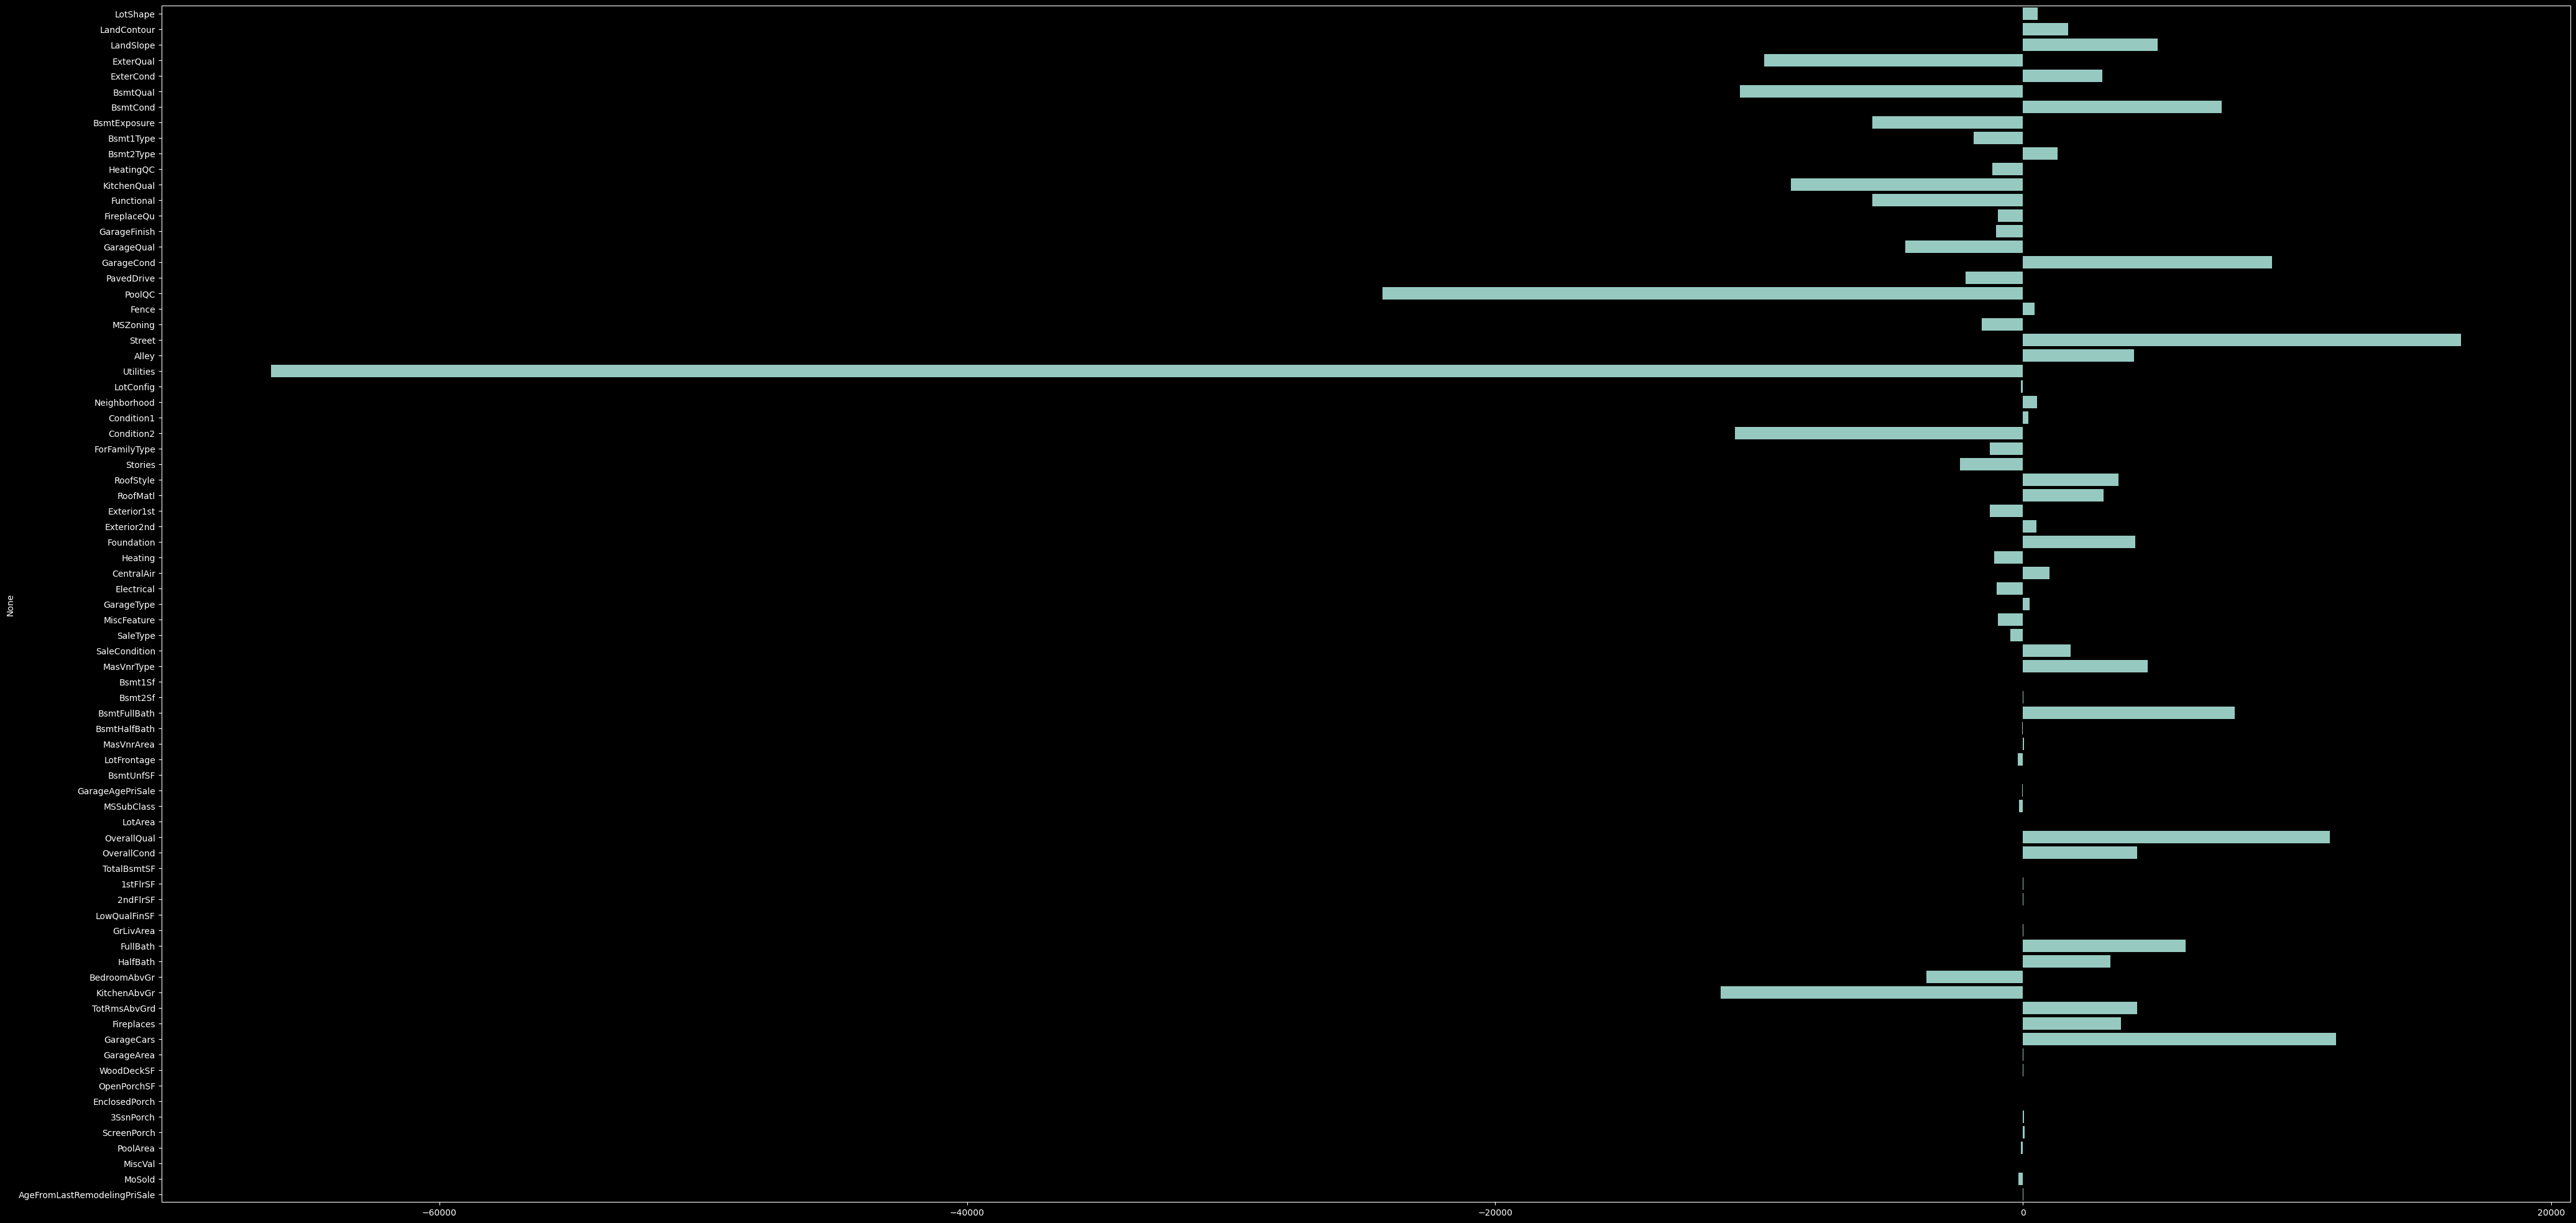

In [652]:
imp = feat_imp(df_proc.drop("SalePrice", axis=1).columns, ln.coef_)

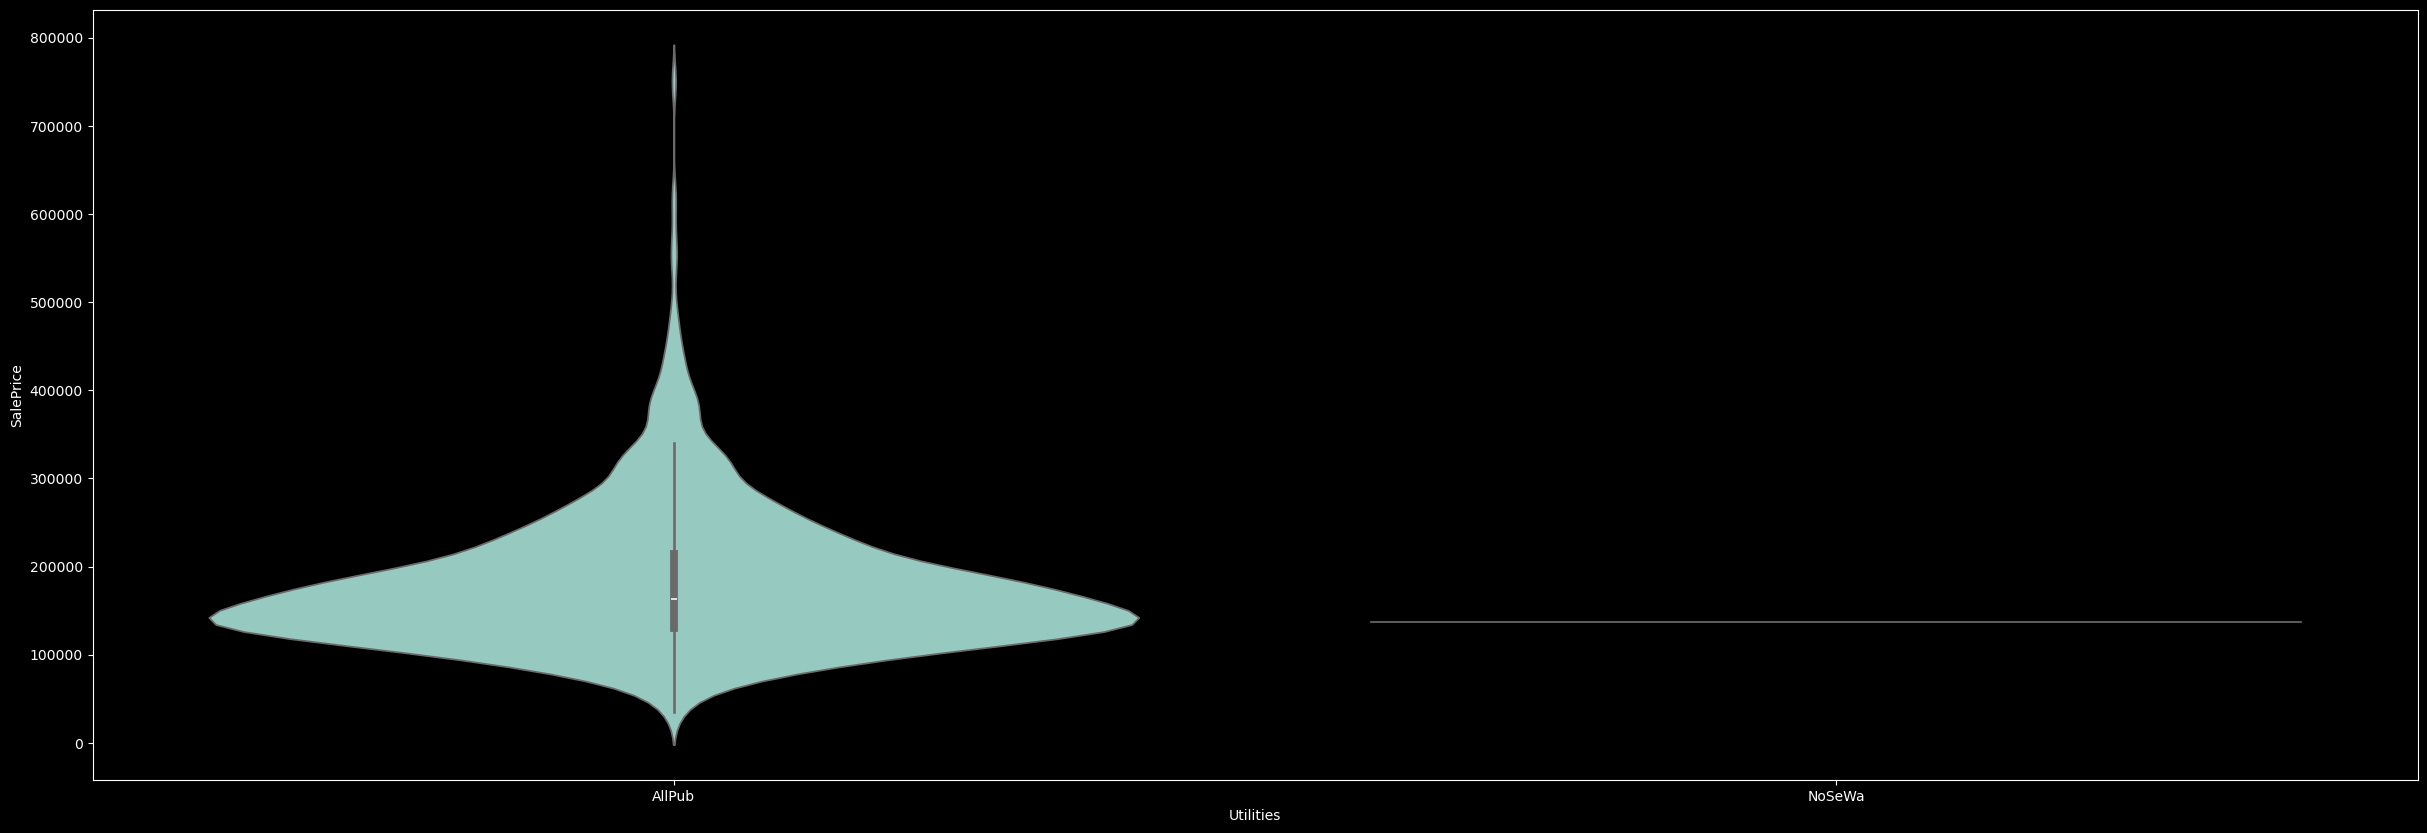

In [653]:
plt.figure(figsize=(30, 10))
sns.violinplot(y=df["SalePrice"], x=df["Utilities"])
plt.show()

In [654]:
df["Utilities"].value_counts().map(lambda x: x / df.shape[0])

Utilities
AllPub    0.999315
NoSeWa    0.000685
Name: count, dtype: float64

In [655]:
df_proc["Utilities"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1455    0.0
1456    0.0
1457    0.0
1458    0.0
1459    0.0
Name: Utilities, Length: 1460, dtype: float64

Imat smisla zsh e tolku negativno. Smeshnoto e sho nemat ni da imat effekt deka 99% od samples imat 0 vrednost za ovaj feature. Zto imat smisla

## Improvments 

### Feature scalling 

In [656]:
data_pipe_scalling = copy.deepcopy(data_pipe)
scaller = make_column_transformer(
    (MinMaxScaler(), df_proc.drop("SalePrice", axis=1).columns), remainder="passthrough"
)
data_pipe_scalling.steps.append(("Scalling", scaller))
data_pipe_scalling.steps.append(
    ("Back to df", FunctionTransformer(func=PdWrapper(scaller)))
)
data_pipe_scalling.fit(df)

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x7fe69c6ecca0>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
       'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'AgeFromLastRemodelingPriSale'],
      dtype='object'))])),
                ('Back to df',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x7fe69bbedae0>))])

In [657]:
df_proc2 = data_pipe_scalling.transform(df)
df_proc2.describe()

,LotShape,LandContour,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,Bsmt1Type,Bsmt2Type,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MSZoning,Street,Alley,Utilities,LotConfig,Neighborhood,Condition1,Condition2,ForFamilyType,Stories,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,Foundation,Heating,CentralAir,Electrical,GarageType,MiscFeature,SaleType,SaleCondition,MasVnrType,Bsmt1Sf,Bsmt2Sf,BsmtFullBath,BsmtHalfBath,MasVnrArea,LotFrontage,BsmtUnfSF,GarageAgePriSale,MSSubClass,LotArea,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,AgeFromLastRemodelingPriSale,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.136073,0.061872,0.031164,0.534703,0.479110,0.302192,0.266267,0.592466,0.409018,0.792123,0.213699,0.496119,0.026370,0.634932,0.428082,0.437945,0.438219,0.071918,0.996747,0.876199,0.757192,0.995890,0.496918,0.000685,0.754795,0.510474,0.253938,0.286888,0.434051,0.123288,0.282055,0.153620,0.687476,0.689315,0.279315,0.207260,0.934932,0.920548,0.414269,0.267295,0.939127,0.754110,0.587443,0.078604,0.031580,0.141781,0.028767,0.064448,0.167341,0.242826,0.265043,0.217043,0.043080,0.566591,0.571918,0.173065,0.190139,0.168035,0.010218,0.222582,0.521689,0.191438,0.358305,0.348858,0.376484,0.204338,0.441781,0.333554,0.109970,0.085302,0.039772,0.006712,0.031377,0.003738,0.002806,0.483811,0.392623,180921.195890
std,0.194099,0.202170,0.138116,0.191427,0.087763,0.175296,0.138040,0.266848,0.351296,0.148722,0.239875,0.221253,0.111283,0.362175,0.297610,0.144580,0.143937,0.248296,0.051015,0.270728,0.158004,0.063996,0.124833,0.026171,0.405659,0.250572,0.108564,0.037006,0.273044,0.299569,0.167000,0.085590,0.228404,0.236038,0.144479,0.059025,0.246731,0.262825,0.322201,0.093026,0.194013,0.220171,0.204758,0.080811,0.109443,0.172970,0.119376,0.112957,0.075437,0.189155,0.231599,0.248827,0.046653,0.153666,0.139100,0.071801,0.088708,0.211394,0.085005,0.098998,0.183639,0.251443,0.101972,0.073446,0.135449,0.214889,0.186829,0.150779,0.146253,0.121126,0.110723,0.057711,0.116161,0.054441,0.032008,0.245784,0.338371,79442.502883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,0.000000,0.000000,0.000000,0.333333,0.500000,0.200000,0.250000,0.500000,0.0

In [658]:
X_tr, X_tst, y_tr, y_tst = train_test_split(
    df_proc2.drop("SalePrice", axis=1),
    df_proc2["SalePrice"],
    test_size=0.2,
    random_state=42,
)

In [659]:
ln = LinearRegression()
ln.fit(X_tr, y_tr)

LinearRegression()

In [660]:
rmse_logs(y_tst, ln.predict(X_tst))

0.5492893923137794

Znachit scaleot na features ne mu menvit mnogu. To go sfakame so to sho imame skros ist rezultat 

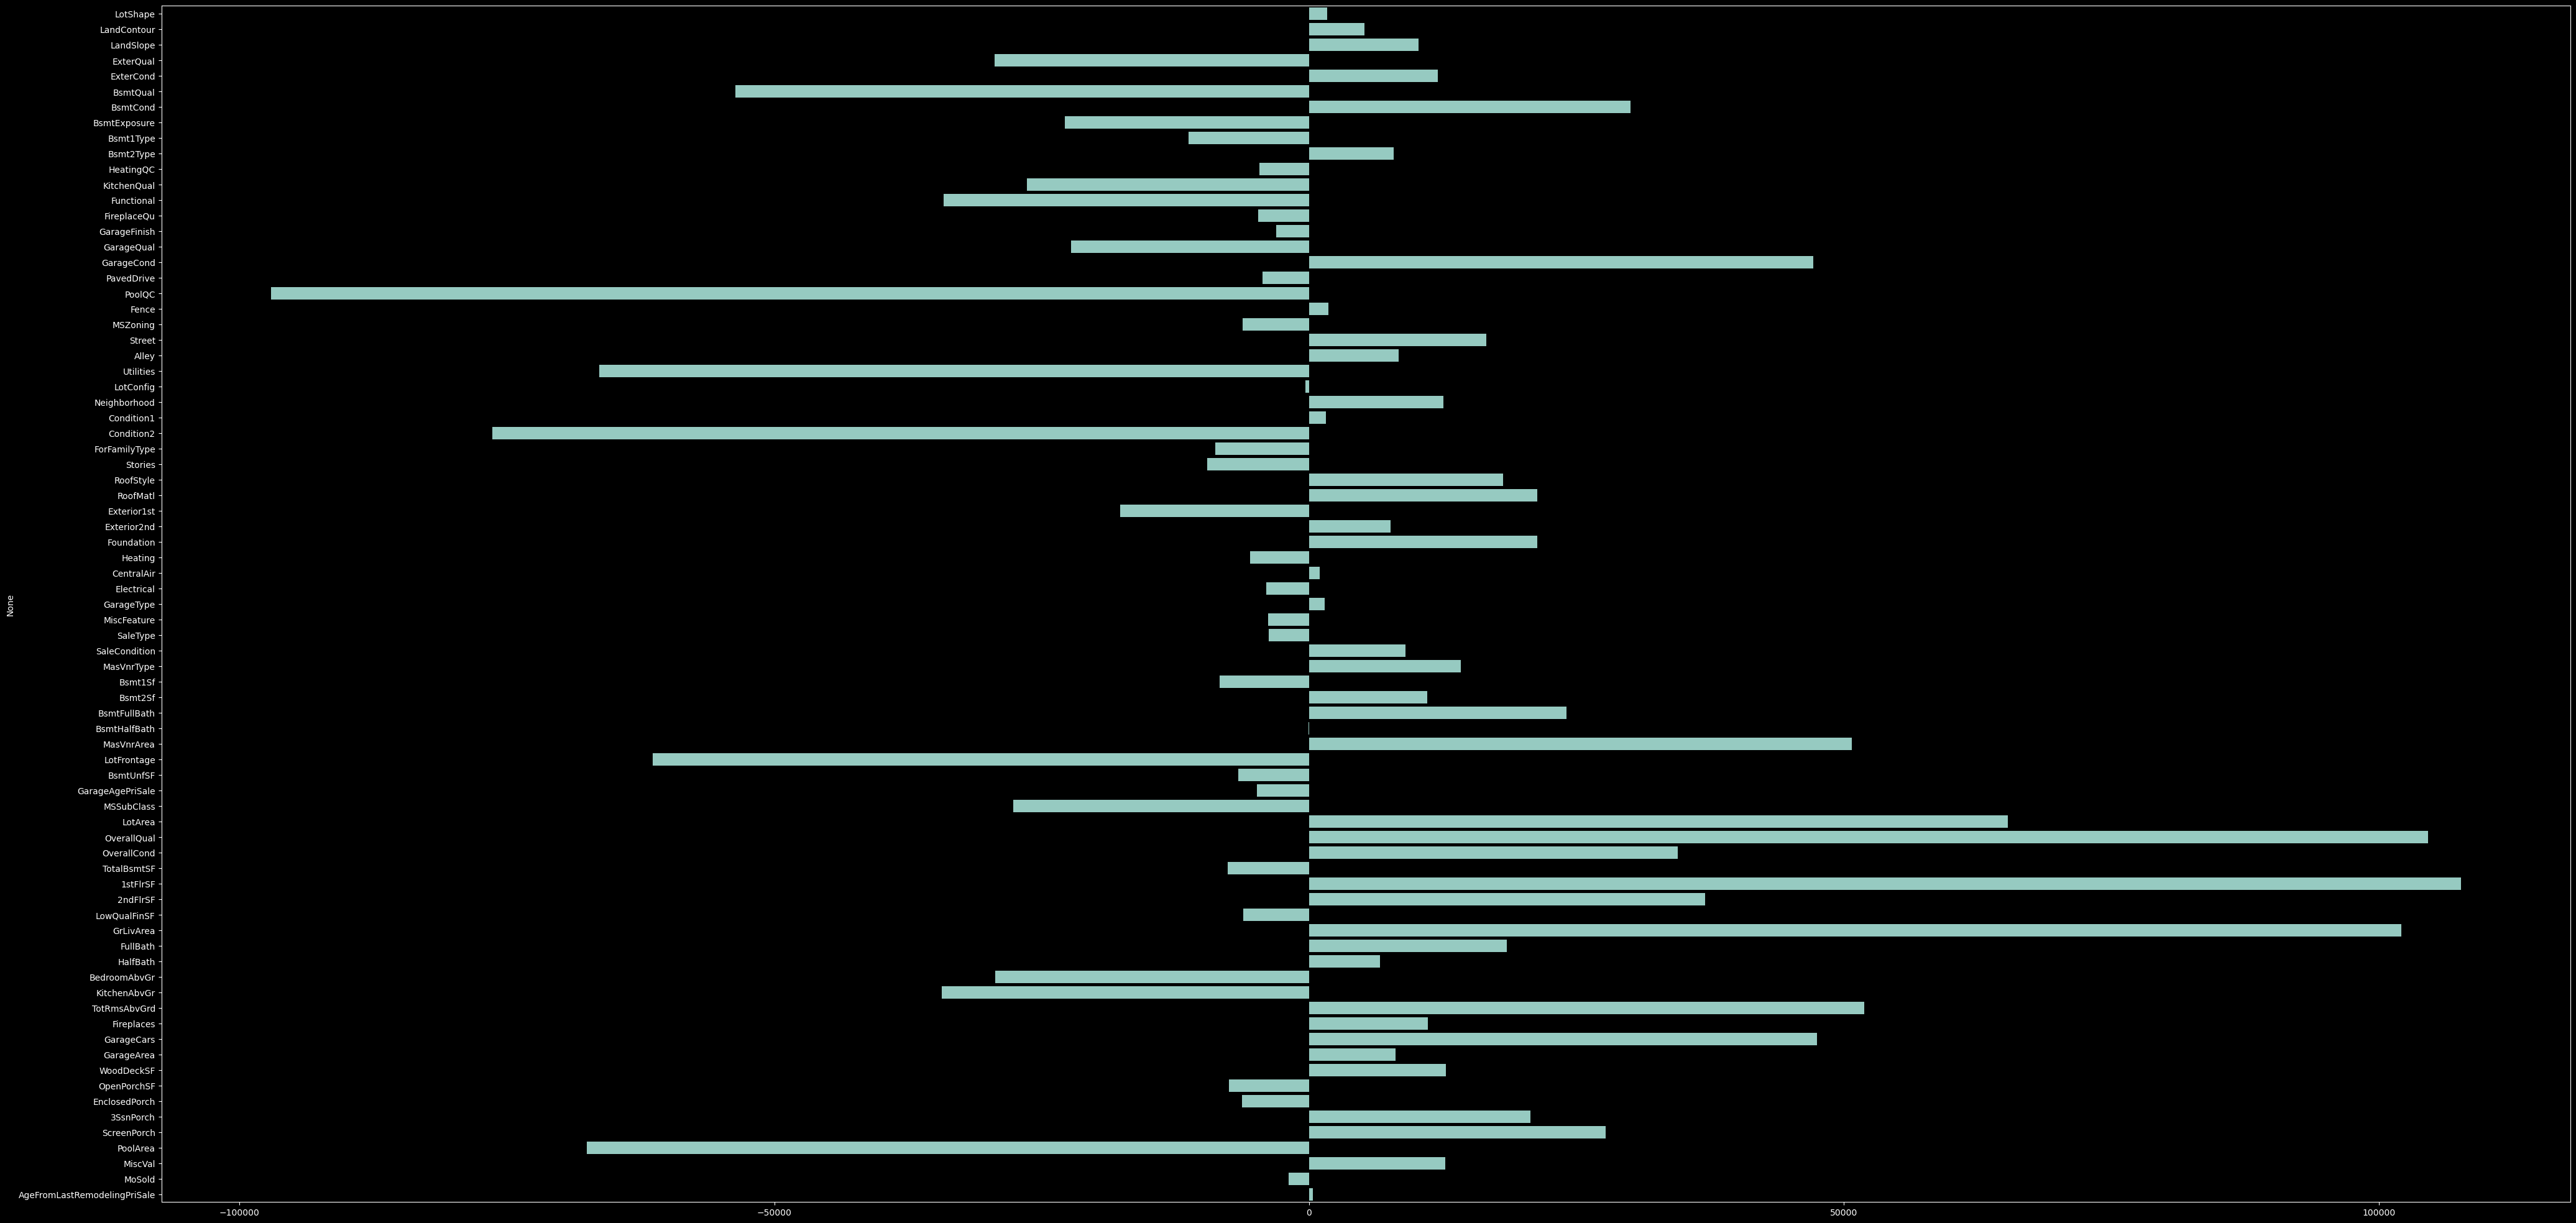

In [661]:
df_feat_imp = feat_imp(df_proc.drop("SalePrice", axis=1).columns, ln.coef_)

Iako nemat neshto golem improvment vo odnos na grehskata. Feature importanceot imat pojke smisla. Ne e samo Utility toj sho turkat dolu. Ova bash ubavo ni ja ilustriat potrebata od scalling vo vakvite modeli. Prethodno tie features sho imaja mnogu golemi vrednosti bea pozitivni, sega otkako so scallingot naprevme site ednakvo da se vazhi za modelot, dobivame podobra distribucija na weights. 

In [662]:
corr = df_proc2.corr()
ng_corr = df_proc2.columns[corr[corr < -0.5]["SalePrice"].notna().values]
ng_corr

Index(['ExterQual', 'BsmtQual', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
       'AgeFromLastRemodelingPriSale'],
      dtype='object')

Gi zemame site features so koi targetot e negativno koreliran, so cel posle da vidime kakvi weights mu assignvit. 

In [663]:
df_feat_imp.loc[ng_corr].map(lambda x: 0 if x < 0 else 1).groupby("Imp").size()

Imp
0    5
1    1
dtype: int64

Nekoj od negativno coreliranite mu davat pozitvni weights, ama na majority ne mu davat

In [664]:
df_feat_imp.min().values[0], df_feat_imp.max().values[0]

(-97062.4009246875, 107659.05463092815)

Magnituadata na weights e mnogu golema, to ni davat indikacija deka ili scallingot ne e bash ko sho trebat ili deka e vreme za regularizacija.

Scallingot ne e problem, zaradi to sho normalno e pogolemi weights da mu davat, deka ***SalePrice*** e dosta golem feature i mu trebat na nekoj nachin da kompenzirat za malite vrednosti ((0,1)) za features.

### Dropping features with weak correlation 

Najprvin ova finta mozhit da ja npareme, deka imame 78 features vo datasetot. Mislam za nashive celi, odnosno kaj sho se trudime da go overfitnime modelot, za so cel da vidime do kolku mozhit ***Linear regression*** da ja fitnit datata, nemat neshto bash mnogu da ni pomozhit. Tuka jas bi gledal pojke na cross validation so cel avrg preformancot na modelot da go podobrime, a ne da dobieme najdobar preformance. 

Najprvin zoshto gore velev deka sakame da go overfitnime modelov. Ako go overvitnime modelov doznavame koja e maksimalnata preciznost sho mozhit da ja dobiet, so to zneme i kolku kompleksen datasetot sprema kolku e kompleksen modelot. Preku toj ratio na kompleksnost doznavame dali treba da ojme so nekoj ushte pokompleksen model, ako ovaj ne vrshit rabota. 

Isto taka vo cvto mozhit da otrkijame nekoj range na data points koj mu se bitni na modelot i na negovite preformansi. 

Najprvin da vidime kolku sakame da e golemo validaciskoto mnozestvo. Ova go preme so cel da imat na sho da testirame. Ako ispadnit test delot da 1% od datasetot, poubo ich da ne go preme. 

In [665]:
portions = []
sz_df = df.shape[0]
for i in range(2, 11):
    tr_size = (sz_df / i) * (i - 1)
    portions.append(tr_size / sz_df)
portions

[0.5,
 0.6666666666666667,
 0.75,
 0.8,
 0.8333333333333334,
 0.8571428571428572,
 0.875,
 0.888888888888889,
 0.9]

### Features with weak correlation 

In [666]:
corr = df_proc2.corr()
weak_feat_query = (corr <= 0.4) & (corr > -0.4)
tr_weak_corr = corr[weak_feat_query]["SalePrice"]
tr_weak_corr.notna().sum()

59

Znachit deka imame mnogu weak correlation features. Sho znachit trebat malce granicite da gi obnovime, deka sigurno nemat da dropnime 59 features.

In [667]:
corr = df_proc2.corr()
weak_feat_query = (corr <= 0.1) & (corr > -0.1)
tr_weak_corr = corr[weak_feat_query]["SalePrice"]
tr_weak_corr.notna().sum()

24

Ke probame so granica 0.1 i 0.2. Deka eptem mnogu losho e 0.2 sho mislat deka ke kompenzirat za brojot na features sho trebat da gi dropnime. 

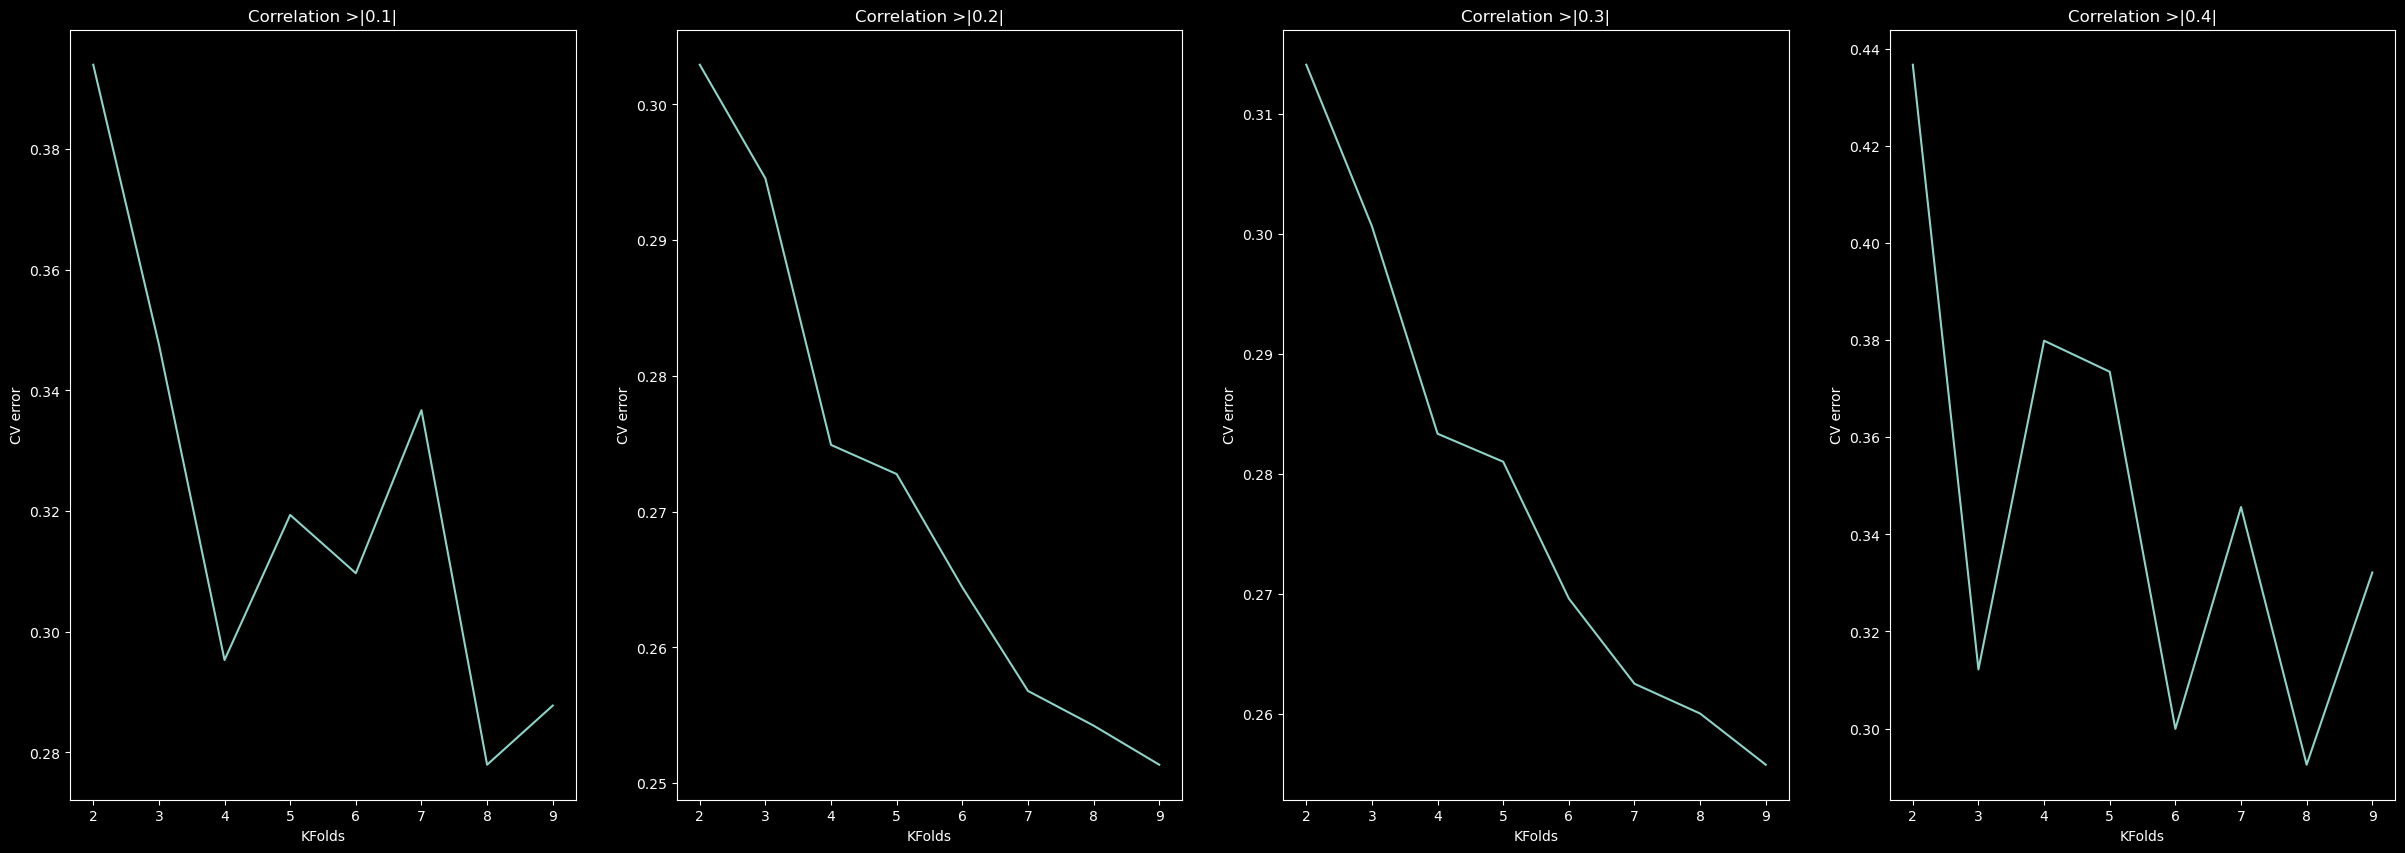

In [668]:
plot_with_correlations(df_proc2,corr_vals=[0.1, 0.2,0.3,0.4],model_constr=LinearRegression)

Ochekuvano e deka za pogolemi vrednosti na folds ke imat podobri rezultati. Sepak idejata tuka mi beshe da vidime on average za razlichni test folds kako se odnesuvat modelot, odnosno kolku dobro generalizirat.

Za correlation >0.2 i >0.3 davat dobri rezultati, sho znachit deka bilo koj od niv mozhit posle da go upotrebime na test datasetot. 

In [669]:
ln=LinearRegression() 
x_tr,y_tr,x_tst,y_tst=test_pairs[0.3]
ln.fit(x_tr,y_tr)

LinearRegression()

In [670]:
rmse_logs(y_tst,ln.predict(x_tst)) 

0.19665401376719166

Ochigledno dobivame podobri rezultati. Toa ni davat na znaenje deka modelot imat mnogu features koj probvit da gi sklopit vo prediction, no mu prat teret, odnosno mu ja namalvat preciznosta. 

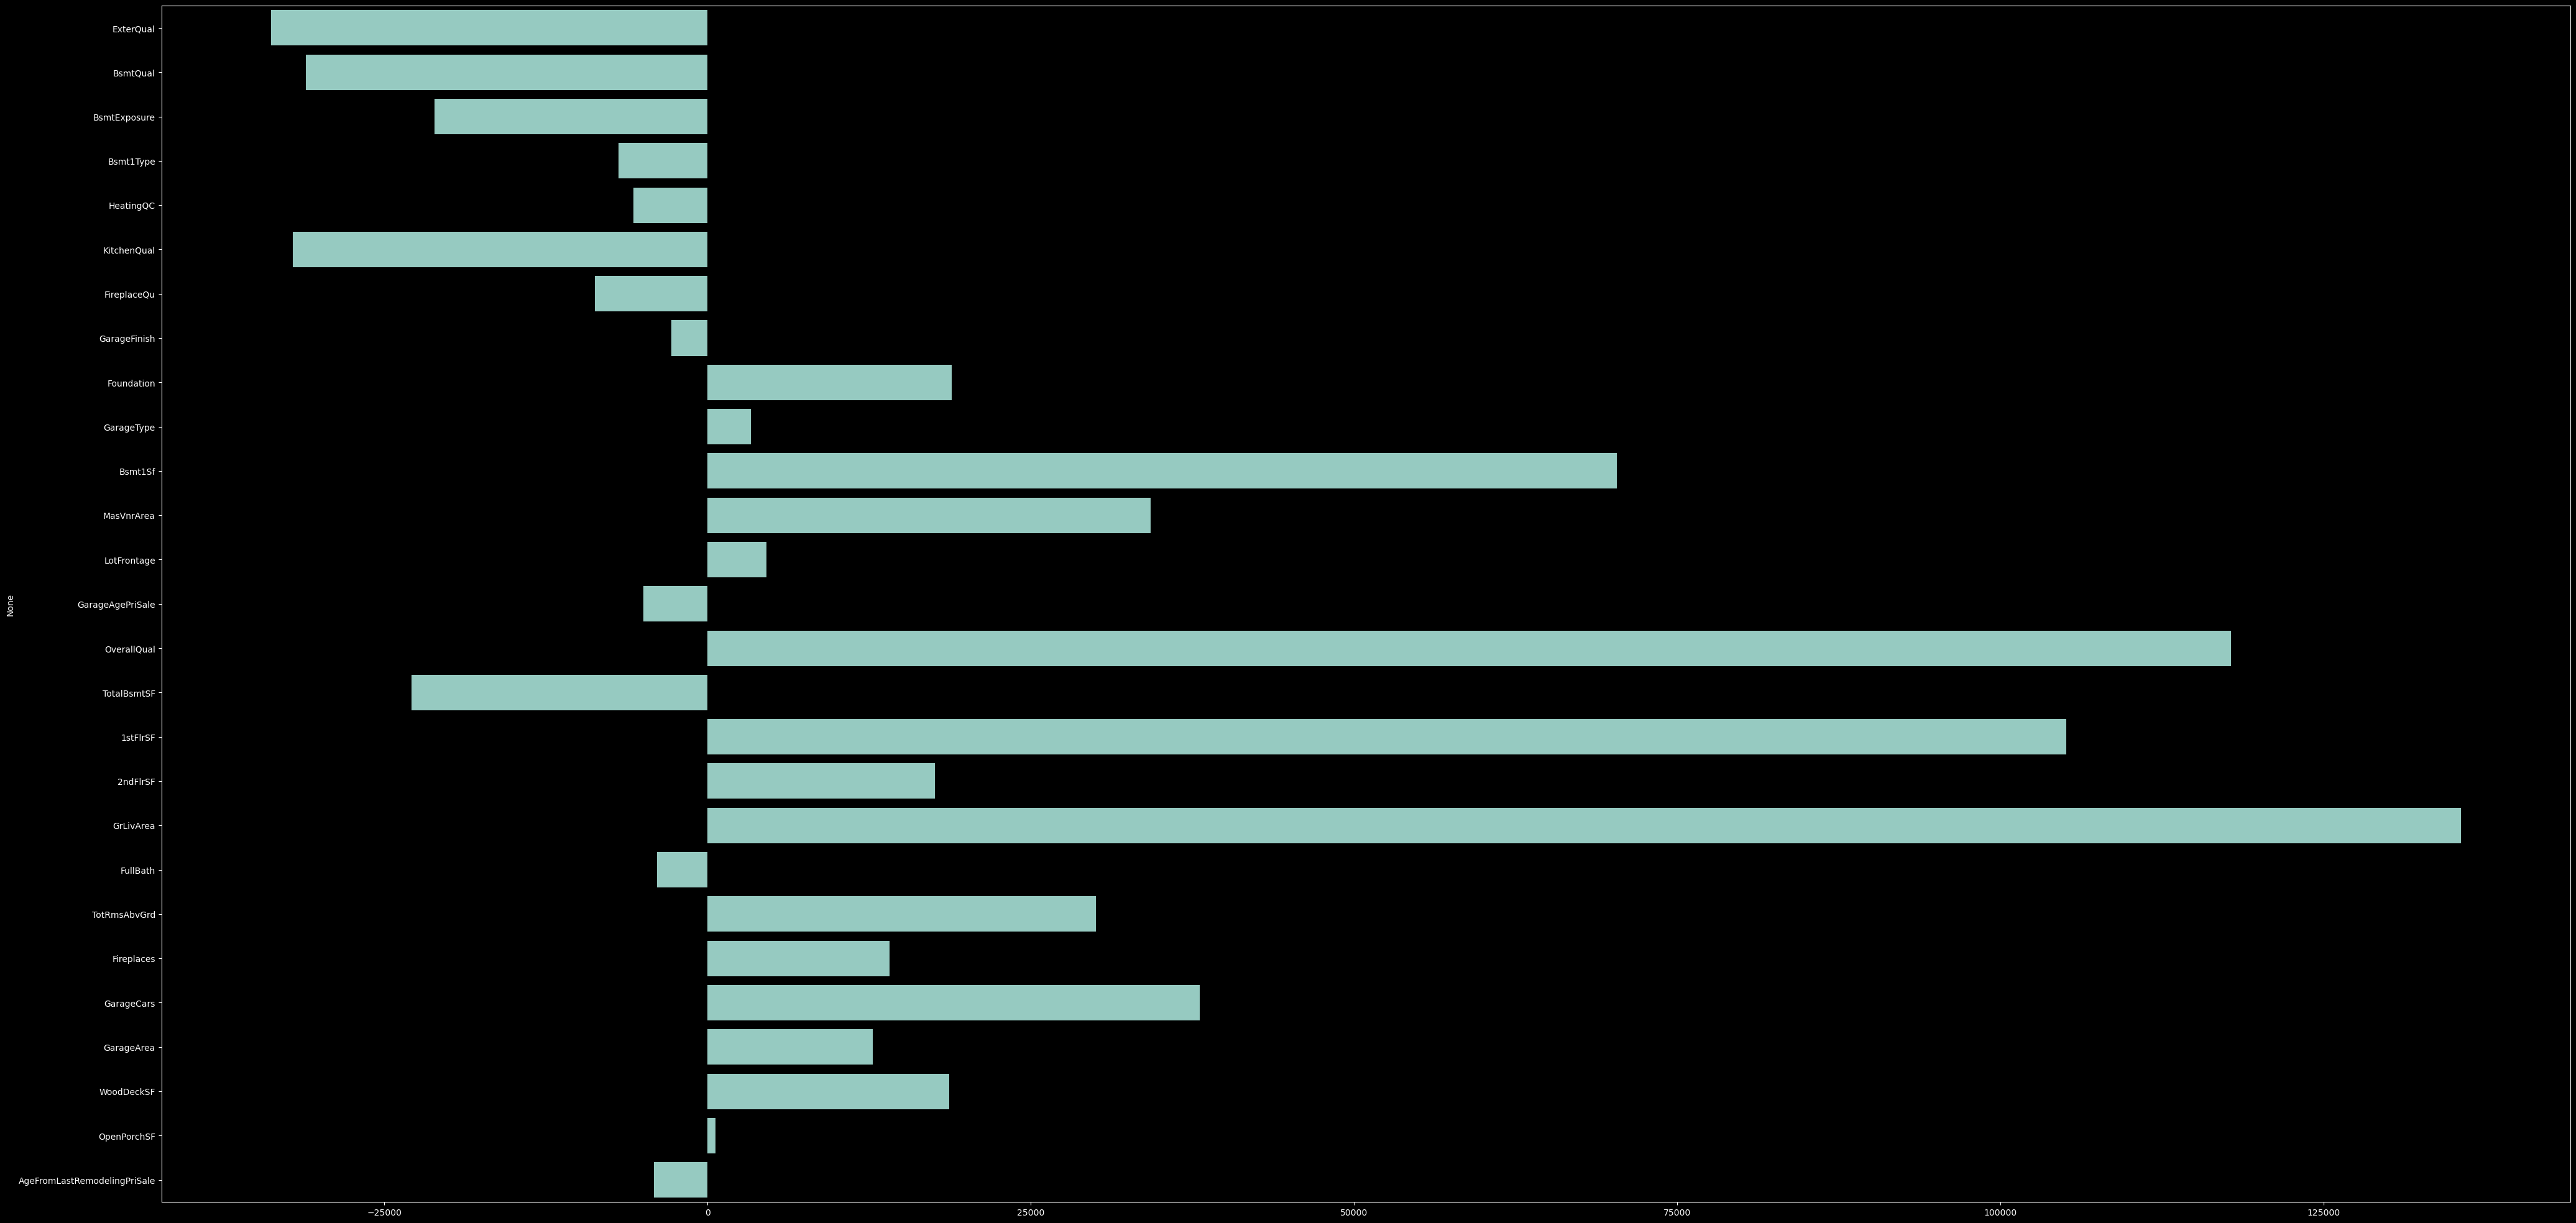

In [671]:
_=feat_imp(x_tr.columns,ln.coef_)

## Dropping multicolinearity

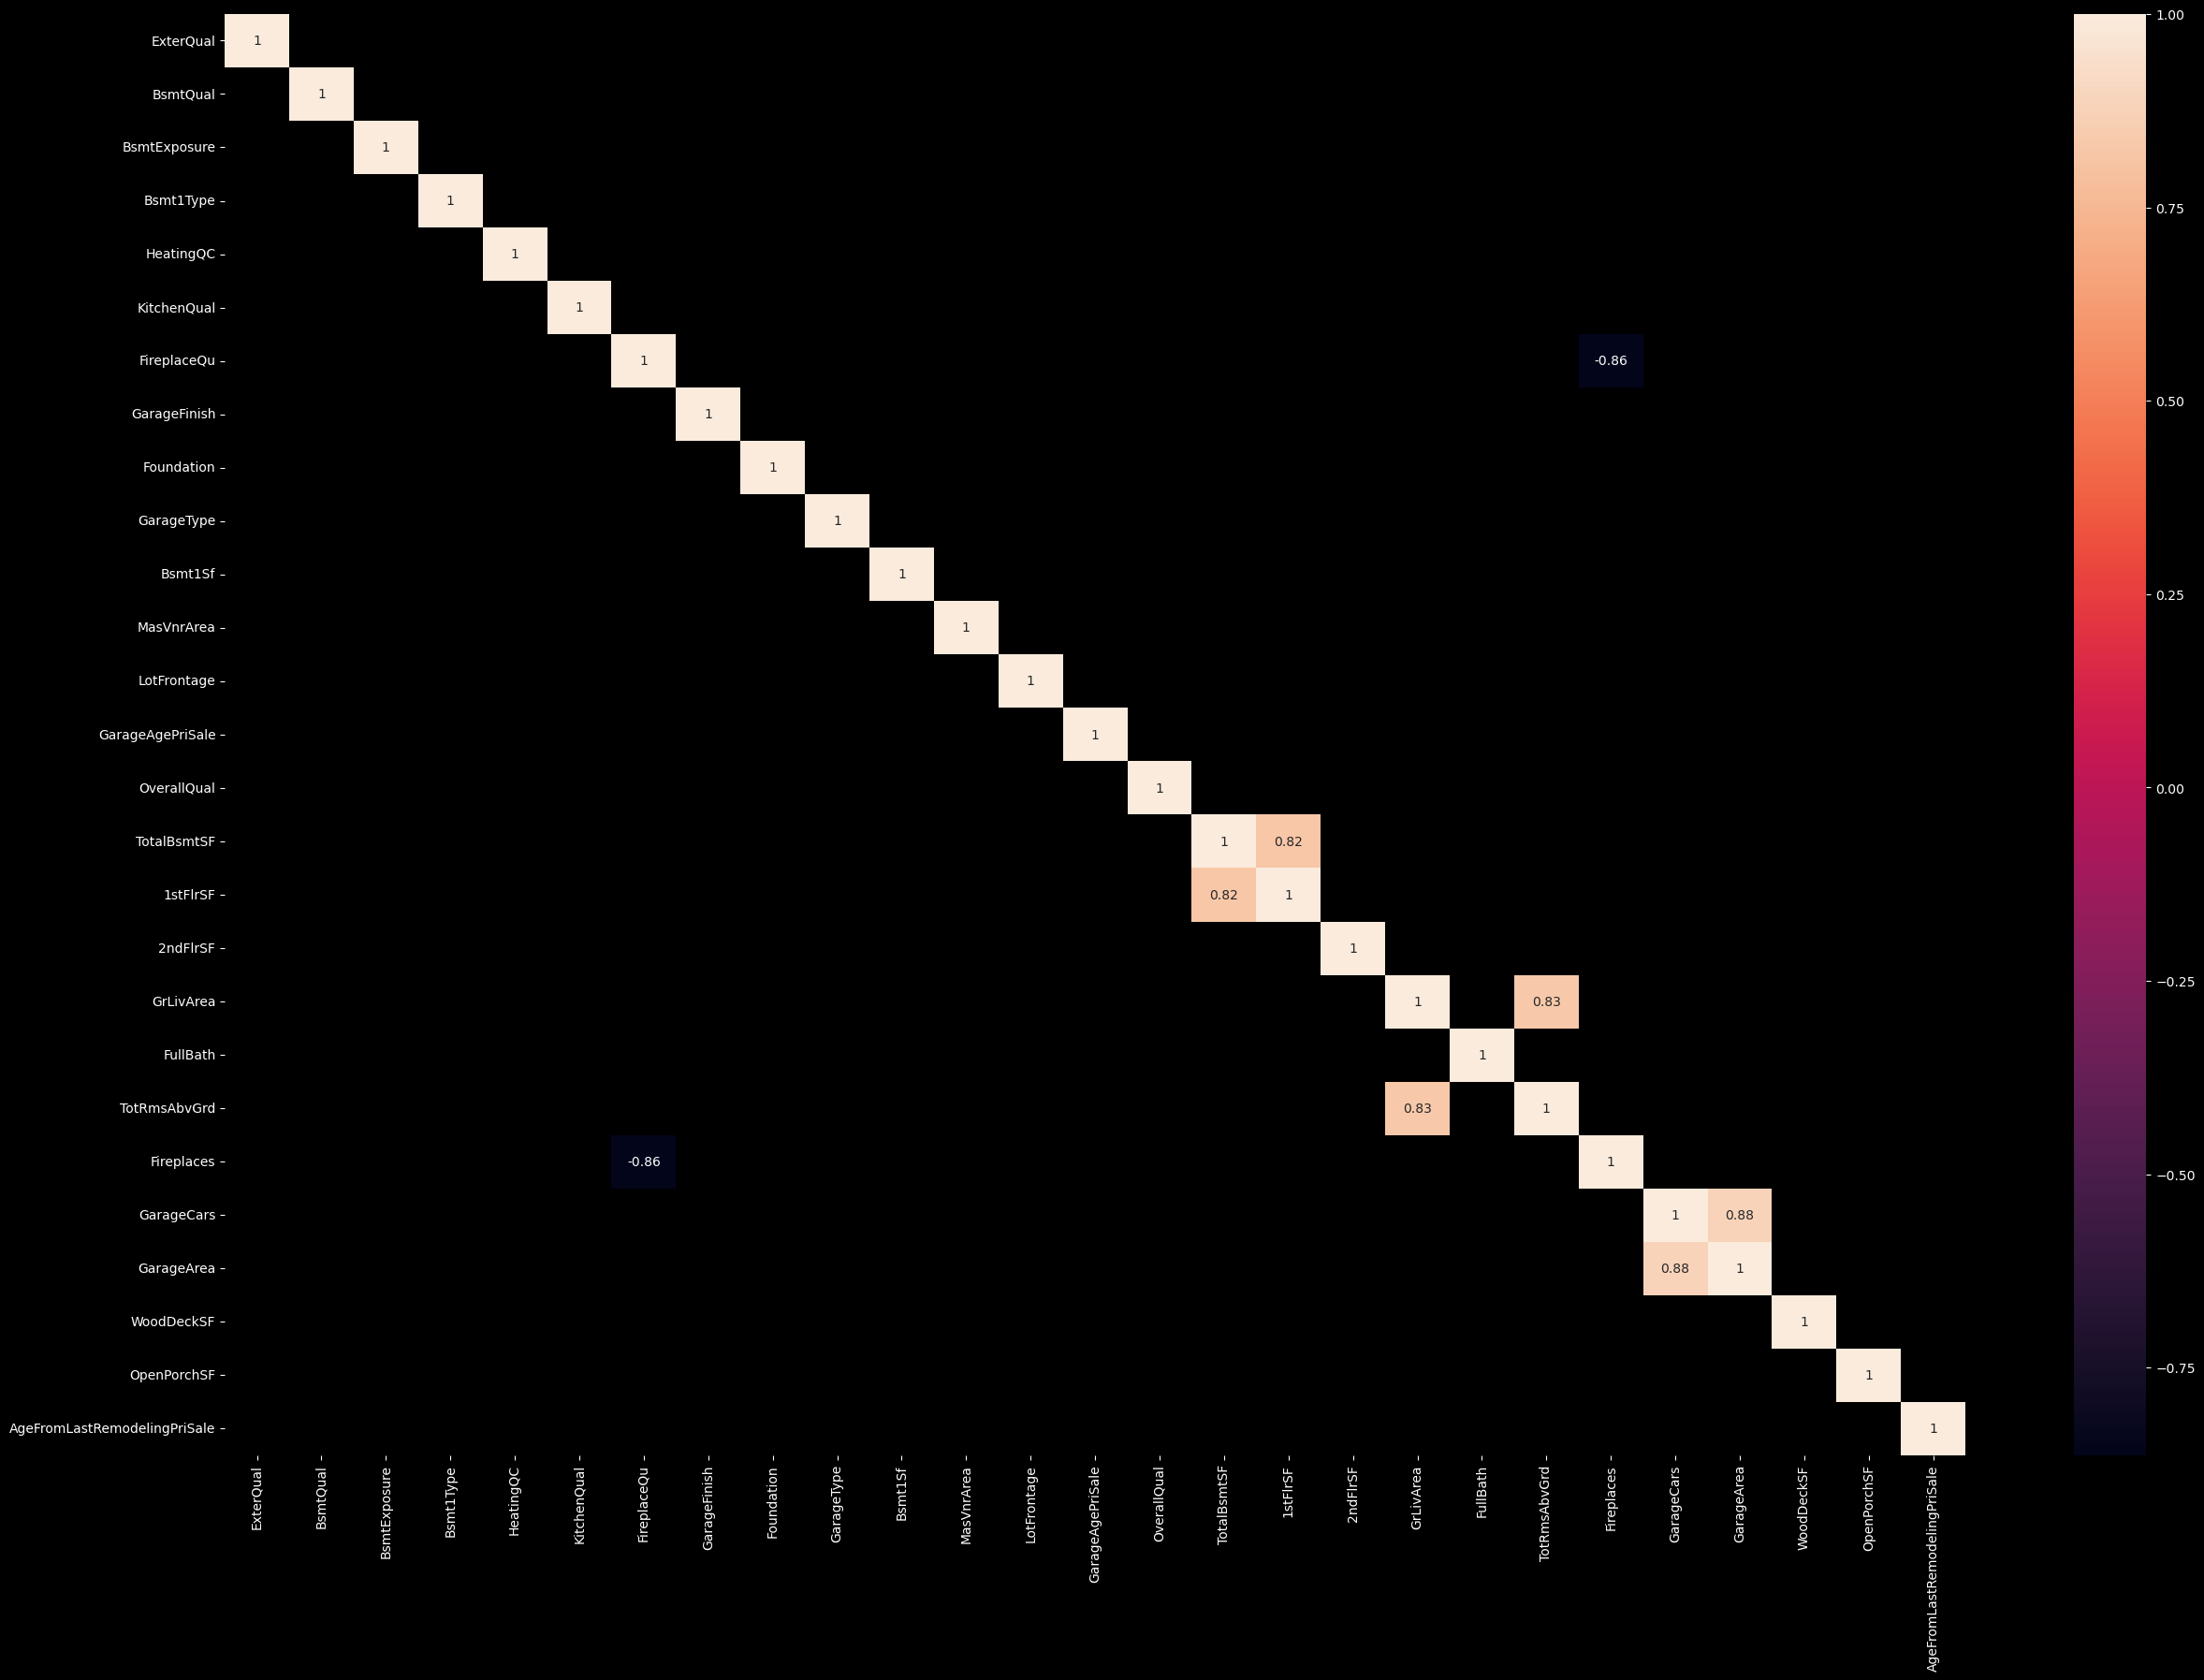

In [672]:
plt.figure(figsize=(30,20))
corr=df_proc2[x_tr.columns].corr()
corr=corr[abs(corr)>=0.8]
sns.heatmap(corr,annot=True) 
plt.show() 

Bidejki Linearna regresija pretpostavuva deka samo koreliranost pomegu target i ostanatite features, ova multikolinearnost ke ni napret problem. 

In [673]:
MULTICOLINEARITY_COLS=[
    'Fireplaces',
    'TotRmsAbvGrd'
]

In [674]:
ln=LinearRegression() 
ln.fit(x_tr.drop(MULTICOLINEARITY_COLS,axis=1),y_tr)

LinearRegression()

In [675]:
rmse_logs(y_tst,ln.predict(x_tst.drop(MULTICOLINEARITY_COLS,axis=1)))

0.19586519648413067

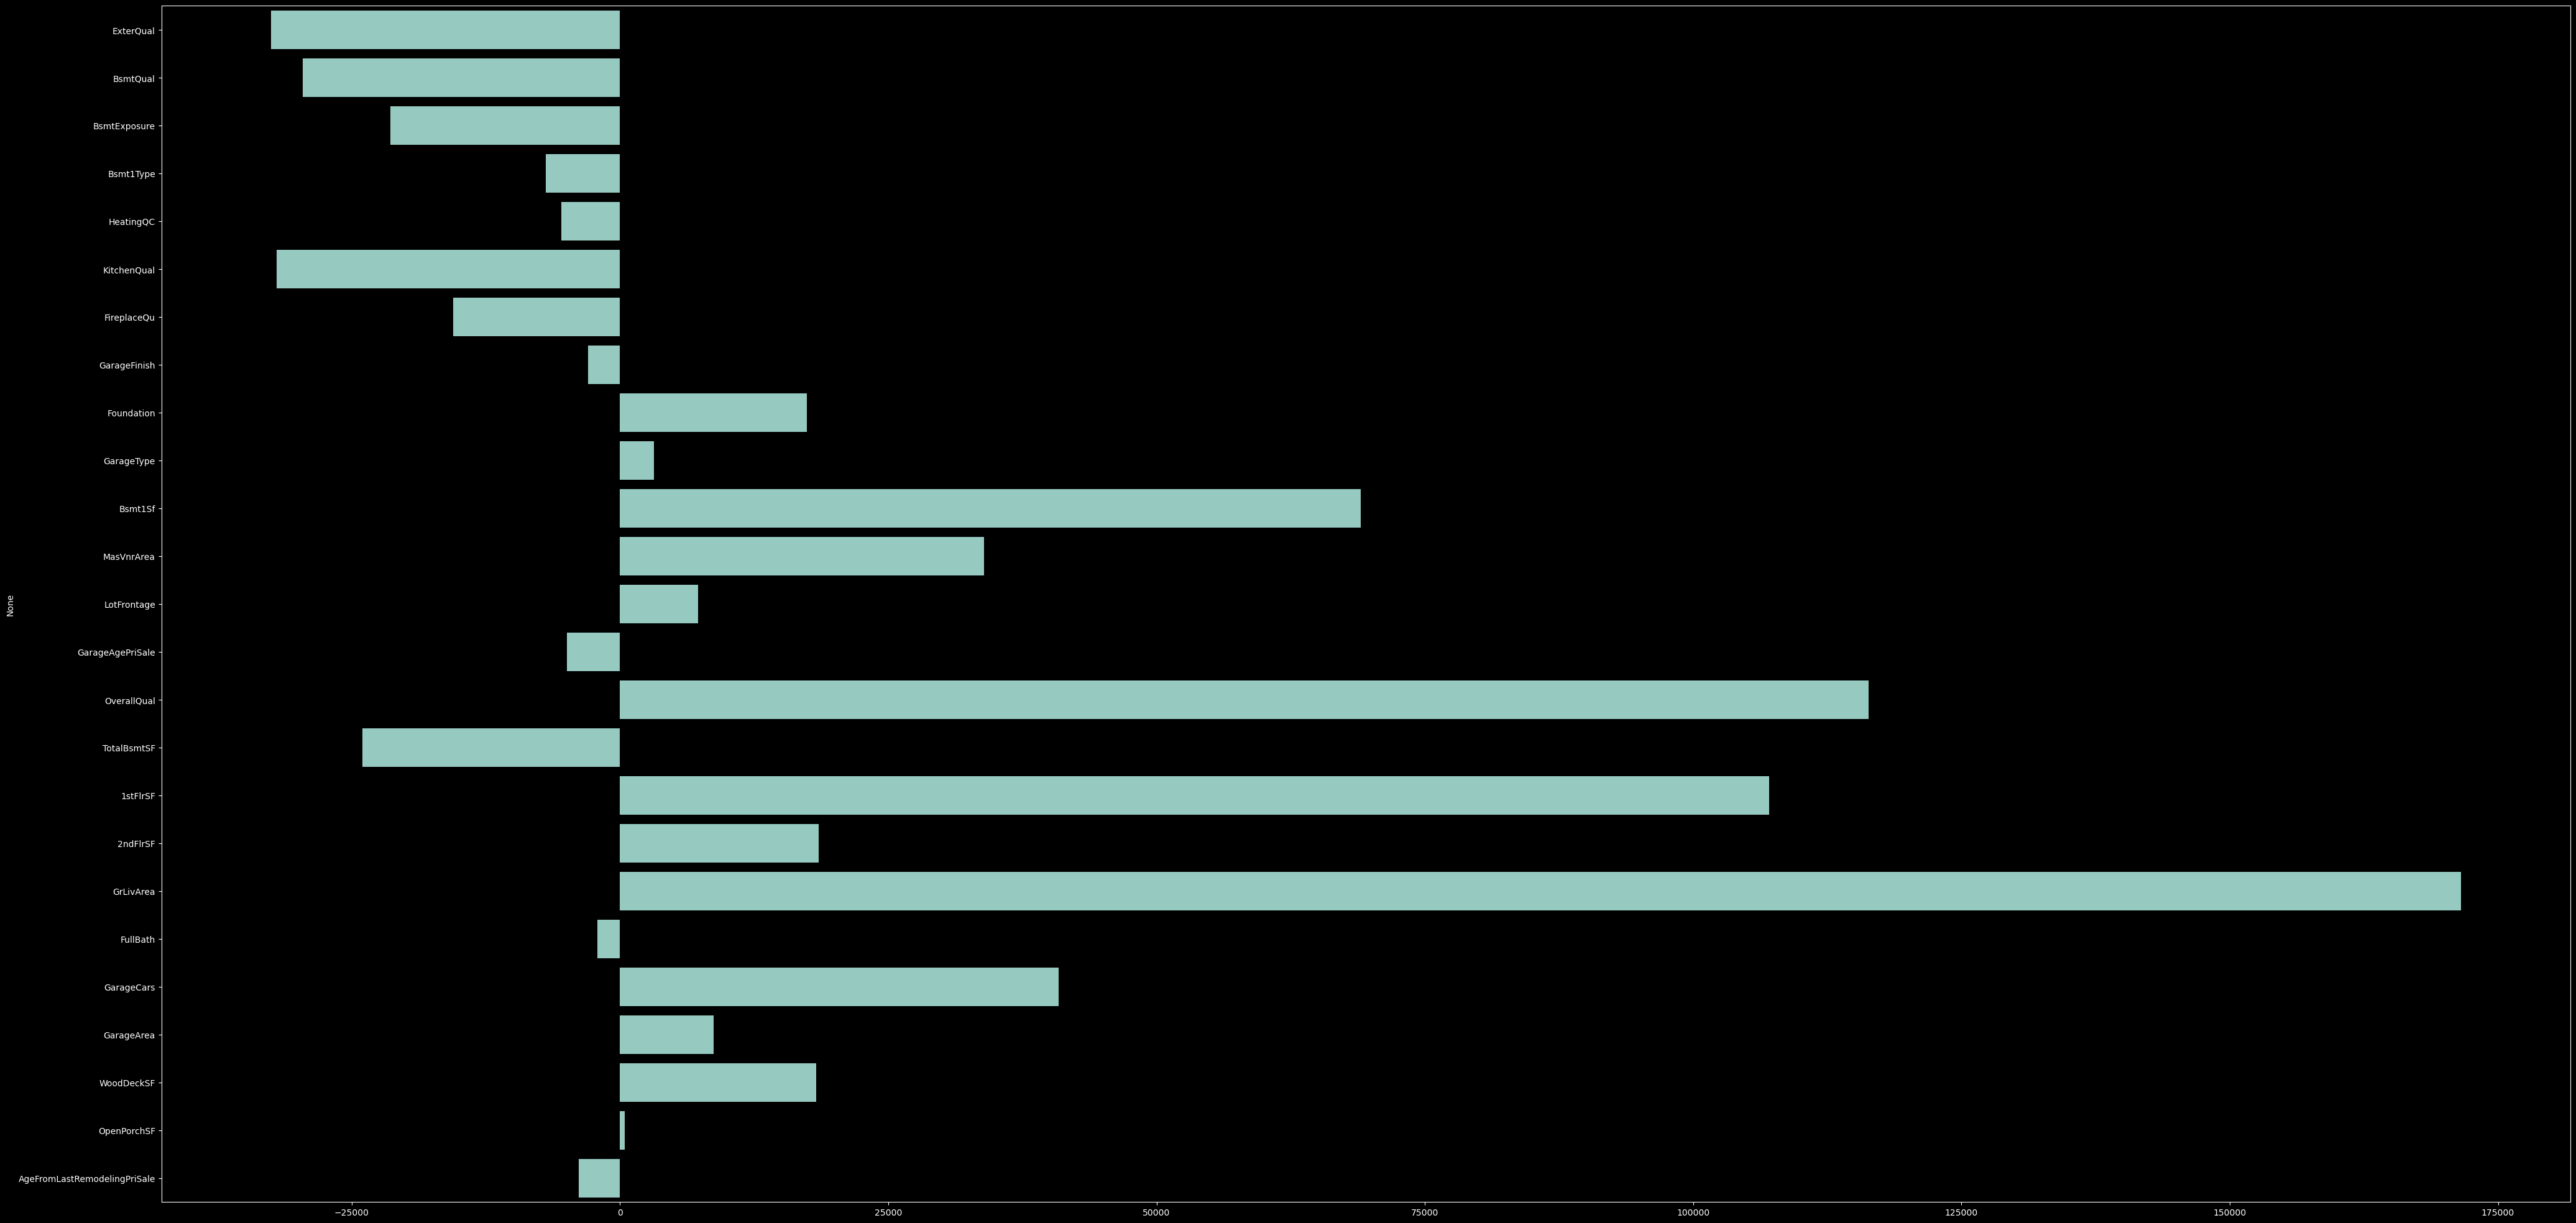

In [676]:
_=feat_imp(x_tr.drop(MULTICOLINEARITY_COLS,axis=1).columns,ln.coef_)

# Ridge regression 

In [677]:
df_ridge=data_pipe_scalling.fit_transform(df)
df_ridge.shape

(1460, 78)

### Dropping multicolinearity

In [678]:
df_ridge.drop(MULTICOLINEARITY_COLS,axis=1,inplace=True) 

### Finding alpha with cv 

In [679]:
x_tr,x_tst,y_tr,y_tst=train_test_split(df_ridge.drop(TARGET_COL,axis=1),df_ridge[TARGET_COL],test_size=0.2,random_state=42)

In [680]:
large_alphas=np.logspace(start=1,stop=5,base=10,num=60)  # 10 ** 2 ->  10 ** 4 
small_alphas=np.logspace(start=1,stop=10,base=0.1,num=60) # 0.1 -> 0.1 ** 10 

ALPHAS=np.sort(np.concatenate([small_alphas,large_alphas]))

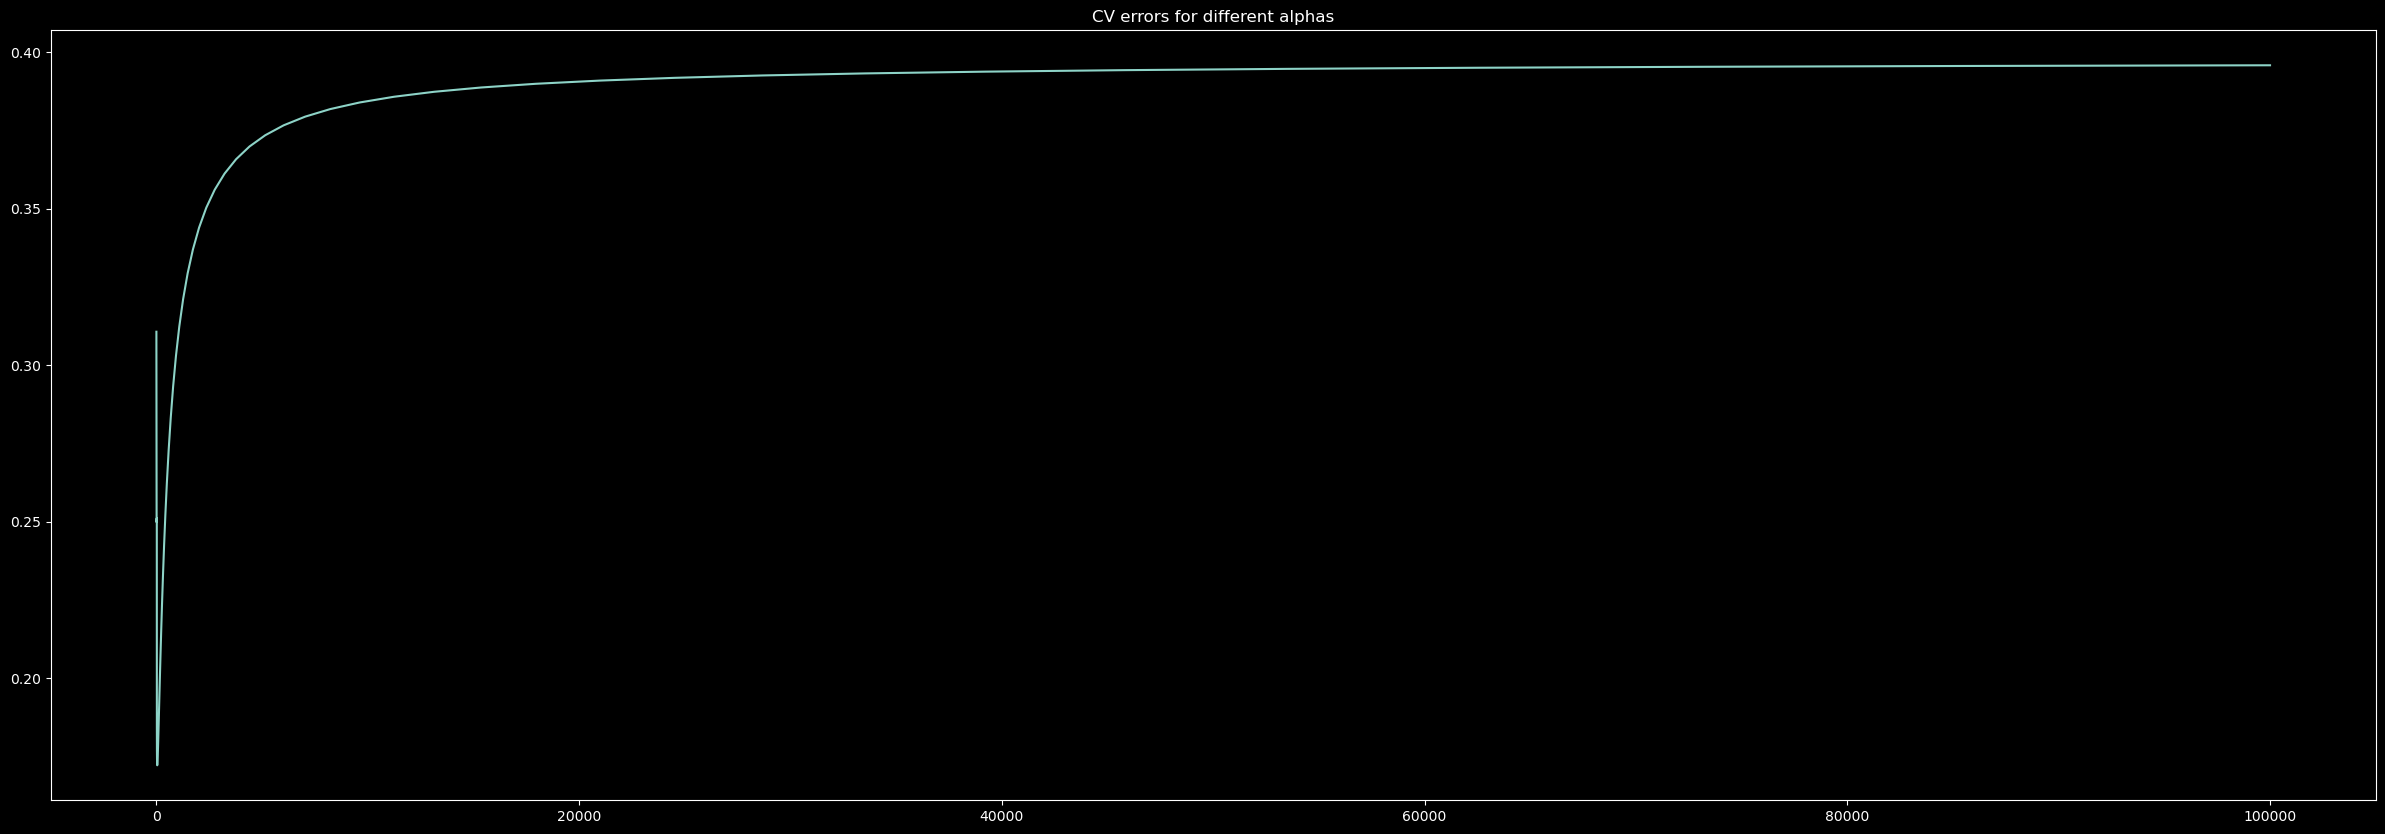

In [681]:
ridge_errs=plot_alphas_valset(x_tr,y_tr,ALPHAS,Ridge)

Kako shto gledame najdobri vrednosti vagat za mali alpha=0, shto znachit deka imat isti preformansi so ***LinearRegression***, shto znachit deka modelot ne overfitvit, tuku underfitvit.

Nema potreba da vidime feature importance,nitu pak so dropvenje na pomalce koreliranite features, i obshto da go probame na test datasetot, bidejki ako ***alpha=0*** togash ***Ridge==LinearRegression***.

# Lasso regression 

In [682]:
df_lasso=data_pipe_scalling.transform(df)
df_lasso.drop(MULTICOLINEARITY_COLS,axis=1,inplace=True)
df_lasso.sample(2)

,LotShape,LandContour,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,Bsmt1Type,Bsmt2Type,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MSZoning,Street,Alley,Utilities,LotConfig,Neighborhood,Condition1,Condition2,ForFamilyType,Stories,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,Foundation,Heating,CentralAir,Electrical,GarageType,MiscFeature,SaleType,SaleCondition,MasVnrType,Bsmt1Sf,Bsmt2Sf,BsmtFullBath,BsmtHalfBath,MasVnrArea,LotFrontage,BsmtUnfSF,GarageAgePriSale,MSSubClass,LotArea,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,AgeFromLastRemodelingPriSale,SalePrice
635,0.000000,0.333333,0.0,1.000000,0.5,0.4,0.50,0.75,0.666667,0.833333,0.0,1.000000,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.50,1.0,1.0,0.0,1.0,0.750,0.125,0.285714,0.428571,0.25,0.6,0.142857,0.857143,0.866667,0.2,0.2,1.0,0.0,1.000000,0.25,1.0,0.0,0.666667,0.045358,0.0,0.000000,0.0,0.00000,0.133562,0.506849,0.000000,1.0,0.044853,0.555556,0.75,0.235679,0.253786,0.697337,0.90035,0.576677,0.666667,0.0,1.00,0.666667,0.0,0.000000,0.000000,0.201097,0.0,0.0,0.0,0.0,0.0,0.181818,0.213115,200000.0
1256,0.333333,0.000000,0.0,0.333333,0.5,0.2,0.25,0.00,0.000000,0.833333,0.0,0.333333,0.0,0.4,0.0,0.4,0.4,0.0,1.0,1.0,0.75,1.0,0.5,0.0,0.0,0.625,0.250,0.285714,0.285714,0.00,0.6,0.142857,0.428571,0.400000,0.4,0.2,1.0,1.0,0.166667,0.25,1.0,0.8,0.333333,0.232814,0.0,0.333333,0.0,0.34625,0.239726,0.287671,0.138889,0.0,0.060777,0.777778,0.50,0.325041,0.379302,0.000000,0.00000,0.311417,0.666667,0.0,0.25,0.333333,0.5,0.487306,0.305718,0.065814,0.0,0.0,0.0,0.0,0.0,0.636364,0.245902,301500.0


/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.464e+11, tolerance: 5.501e+08
  model = cd_fast.enet_coordinate_descent(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.018e+10, tolerance: 5.256e+08
  model = cd_fast.enet_coordinate_descent(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

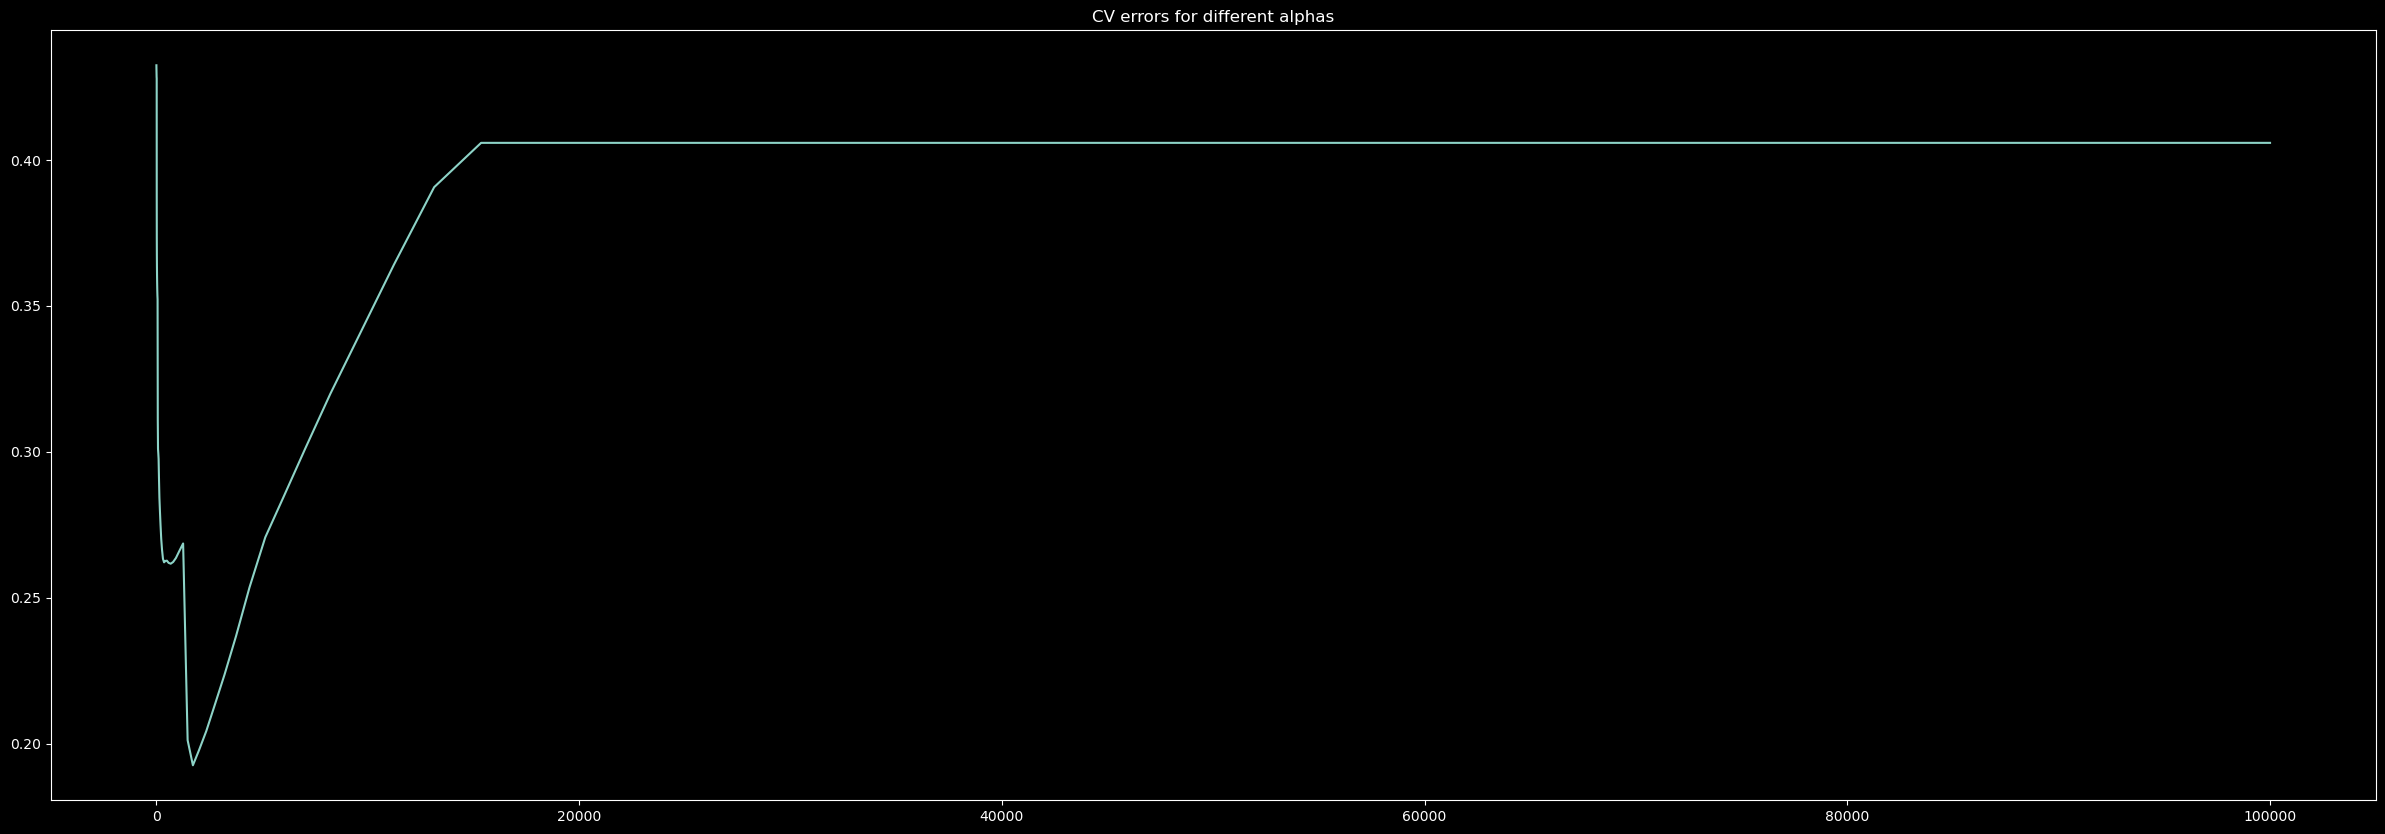

In [683]:
x_tr,x_tst,y_tr,y_tst=train_test_split(df_lasso.drop(TARGET_COL,axis=1),df_lasso[TARGET_COL])
errs=plot_alphas_valset(x_tr,y_tr,alphas=ALPHAS,model_constr=Lasso)

Go probav so ushte pojke cycles, nekade 1e6, ama ne konvergiraa prvite nekolku, pa si rekov mnogu vreme ke fatit za neshto sho nemat da konvergirat i go namaliv max_iter. 

In [684]:
err_min=errs.min().values[0]
errs=errs[errs==err_min].dropna()
best_alpha=errs.index.values[0]
best_alpha

1726.9832906594343

Imat smisla zsh so olku golema brojka za regularizacija. Gore vidovme ako gi dropnime kolonite sho se malce kolerirani dobivame mnogu pomal error, a lasso deka mozhit da gi dropnit barat mnogu pojke regularizacija. 

In [685]:
lasso=Lasso(alpha=best_alpha)
lasso.fit(x_tr,y_tr)

Lasso(alpha=1726.9832906594343)

In [686]:
rmse_logs(y_tst,lasso.predict(x_tst))

0.19752406115191246

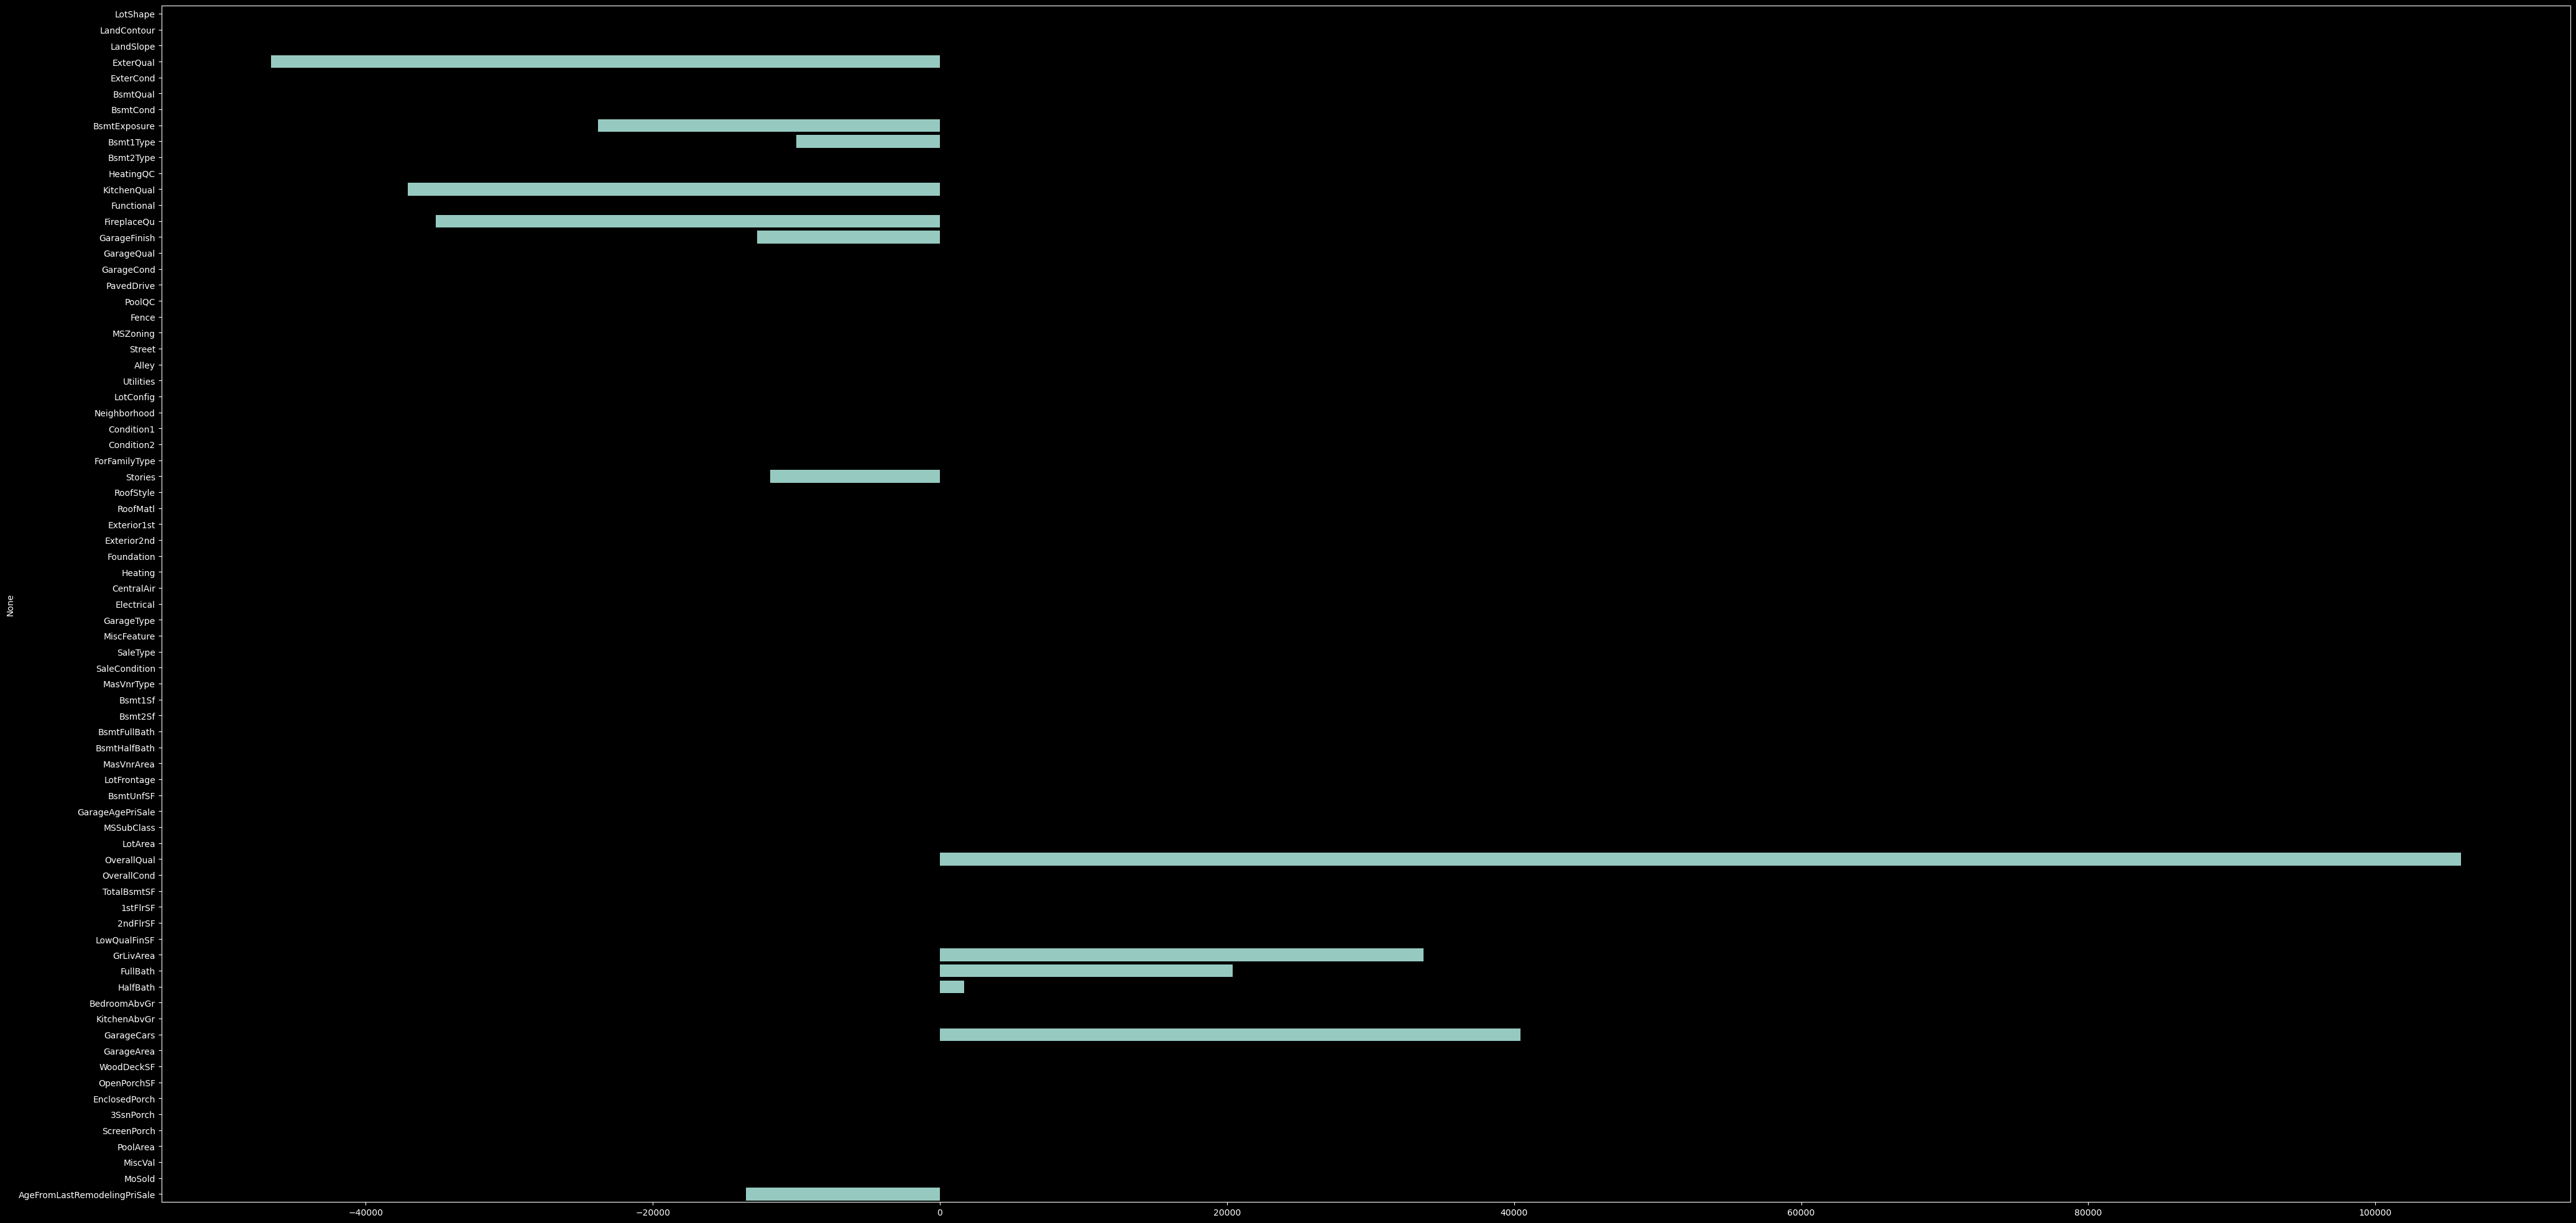

In [687]:
_=feat_imp(x_tr.columns,lasso.coef_)

In [688]:
zerod_cols=np.where(lasso.coef_==0)[0]
zerod_cols.shape

(62,)

In [689]:
zerod_cols=x_tr.columns[zerod_cols]
zerod_cols

Index(['LotShape', 'LandContour', 'LandSlope', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'Bsmt2Type', 'HeatingQC', 'Functional', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MSZoning', 'Street',
       'Alley', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1',
       'Condition2', 'ForFamilyType', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'Foundation', 'Heating', 'CentralAir', 'Electrical',
       'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition', 'MasVnrType',
       'Bsmt1Sf', 'Bsmt2Sf', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea',
       'LotFrontage', 'BsmtUnfSF', 'GarageAgePriSale', 'MSSubClass', 'LotArea',
       'OverallCond', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'BedroomAbvGr', 'KitchenAbvGr', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold'],
      dtype='object')

In [690]:
cols_under_03=cols_corr_in_range(i=.3,corr=df_lasso.corr())
cols_under_03

array(['LotShape', 'LandContour', 'LandSlope', 'ExterCond', 'BsmtCond',
       'Bsmt2Type', 'Functional', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MSZoning', 'Street', 'Alley',
       'Utilities', 'LotConfig', 'Neighborhood', 'Condition1',
       'Condition2', 'ForFamilyType', 'Stories', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'Heating', 'CentralAir',
       'Electrical', 'MiscFeature', 'SaleType', 'SaleCondition',
       'MasVnrType', 'Bsmt2Sf', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtUnfSF', 'MSSubClass', 'LotArea', 'OverallCond',
       'LowQualFinSF', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold'], dtype=object)

In [691]:
zerod_cols.isin(cols_under_03).sum()

48

Zto ni izlegveshe LinearRegression tolku dobar ko ke gi dropevme kolonite. Problemot so Ridge e to sho nemozhit da gi dropnit. Samo eden feature go imame zafrknato so korelacijata. 

# Elastic net 

In [692]:
df_elastic=data_pipe.transform(df)
df_elastic.sample(2)

,LotShape,LandContour,LandSlope,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,Bsmt1Type,Bsmt2Type,HeatingQC,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MSZoning,Street,Alley,Utilities,LotConfig,Neighborhood,Condition1,Condition2,ForFamilyType,Stories,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,Foundation,Heating,CentralAir,Electrical,GarageType,MiscFeature,SaleType,SaleCondition,MasVnrType,Bsmt1Sf,Bsmt2Sf,BsmtFullBath,BsmtHalfBath,MasVnrArea,LotFrontage,BsmtUnfSF,GarageAgePriSale,MSSubClass,LotArea,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,AgeFromLastRemodelingPriSale
1165,1.0,0.0,0.0,1.0,2.0,1.0,2.0,3.0,5.0,5.0,0.0,1.0,0.0,5.0,1.0,2.0,2.0,0.0,4.0,4.0,3.0,1.0,1.0,0.0,4.0,16.0,2.0,2.0,2.0,0.0,1.0,1.0,12.0,13.0,2.0,1.0,1.0,4.0,1.0,1.0,6.0,5.0,3.0,0.0,0.0,0.0,0.0,268.0,79.0,1502.0,0.0,20.0,9541.0,7.0,5.0,1502.0,1502.0,0.0,0.0,1502.0,2.0,0.0,3.0,1.0,7.0,0.0,2.0,644.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,9.0,233170.0,0.0
1375,1.0,2.0,0.0,1.0,2.0,1.0,2.0,0.0,5.0,5.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,4.0,4.0,3.0,1.0,1.0,0.0,4.0,23.0,2.0,2.0,2.0,0.0,1.0,1.0,12.0,13.0,2.0,1.0,1.0,4.0,1.0,1.0,6.0,5.0,1.0,0.0,0.0,0.0,0.0,80.0,89.0,1571.0,0.0,20.0,10991.0,8.0,5.0,1571.0,1571.0,0.0,0.0,1571.0,2.0,0.0,3.0,1.0,7.0,1.0,3.0,722.0,100.0,36.0,0.0,0.0,0.0,0.0,0.0,12.0,239000.0,0.0


In [693]:
df_elastic.shape

(1460, 78)

Vo elastic net nemat da preme drop na MULTICOLINEARITY deka modelot e spremen da se sprevit so niv. 

Pretpostavka moja e deka l1_ratio sho pomal to podobar model. Ova pretpostavka ja baziram na faktot deka vidovme podobruvanje vo preformaniste na modelite vo slucai kade shto odzemavme dosta features od datasetot. 

In [694]:
l1_ratio=np.linspace(0.001,stop=1,num=10)
alphas=ALPHAS

In [695]:
x_tr,x_tst,y_tr,y_tst=train_test_split(df_elastic.drop(TARGET_COL,axis=1),df_elastic[TARGET_COL],test_size=.2,random_state=42)

Odbrav HalvingGridSearchCV za so cel pobrzo da se izvrshit, ama se izlazav, ich ne beshe pobrzo. 

In [696]:
fine_tuner=HalvingGridSearchCV(
    estimator=ElasticNet(max_iter=int(1e5)),
    param_grid={
        "l1_ratio": l1_ratio,
        "alpha":ALPHAS 
    },
    scoring=house_pricing_metric,
    cv=6
)
fine_tuner.fit(x_tr,y_tr)

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.222e+07, tolerance: 9.053e+06
  model = cd_fast.enet_coordinate_descent(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e+07, tolerance: 7.259e+06
  model = cd_fast.enet_coordinate_descent(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

KeyboardInterrupt: 

In [ ]:
fine_tuner.best_score_

0.2820033606335537

In [ ]:
best_estimator=fine_tuner.best_estimator_
best_estimator.fit(x_tr,y_tr)

ElasticNet(alpha=17957.14494371641, l1_ratio=1.0, max_iter=100000)

In [ ]:
rmse_logs(y_tst,best_estimator.predict(x_tst))

0.20097156742096497

In [ ]:
fine_tuner.cv_results_

{'iter': array([0, 0, 0, ..., 4, 4, 4]),
 'n_resources': array([ 12,  12,  12, ..., 972, 972, 972]),
 'mean_fit_time': array([1.80494785e-03, 1.53692563e-03, 1.48204962e-03, ...,
        4.05138898e+00, 4.06078716e+00, 4.06635328e+00]),
 'std_fit_time': array([3.96877708e-04, 1.08257147e-04, 1.24048281e-04, ...,
        2.81109568e-01, 2.70972296e-01, 2.73867463e-01]),
 'mean_score_time': array([0.00122114, 0.00116138, 0.00104415, ..., 0.00168912, 0.0017186 ,
        0.00170354]),
 'std_score_time': array([1.03825239e-04, 1.45528809e-04, 3.03946287e-05, ...,
        5.05435517e-05, 9.35553883e-05, 5.23235843e-05]),
 'param_alpha': masked_array(data=[1.0000000000000006e-10, 1.0000000000000006e-10,
                    1.0000000000000006e-10, ..., 0.00012638482029342975,
                    6.260516572014816e-05, 3.101168926574776e-05],
              mask=[False, False, False, ..., False, False, False],
        fill_value=1e+20),
 'param_l1_ratio': masked_array(data=[0.001, 0.112, 0.223, 

In [ ]:
splits_keys=[f'split{i}_test_score' for i in range(6)]
cv_res=fine_tuner.cv_results_
split_matrix=[]
for split_key in splits_keys:
    split_matrix.append(cv_res[split_key])
split_matrix=np.array(split_matrix)
split_matrix=split_matrix.T
cv_avrgs=[]
for split in split_matrix:
    cv_avrgs.append(np.mean(split))

In [ ]:
alphas_params=[]
l1_ratio_params=[]

for p in fine_tuner.cv_results_['params']: 
    alphas_params.append(p['alpha'])
    l1_ratio_params.append(p['l1_ratio'])

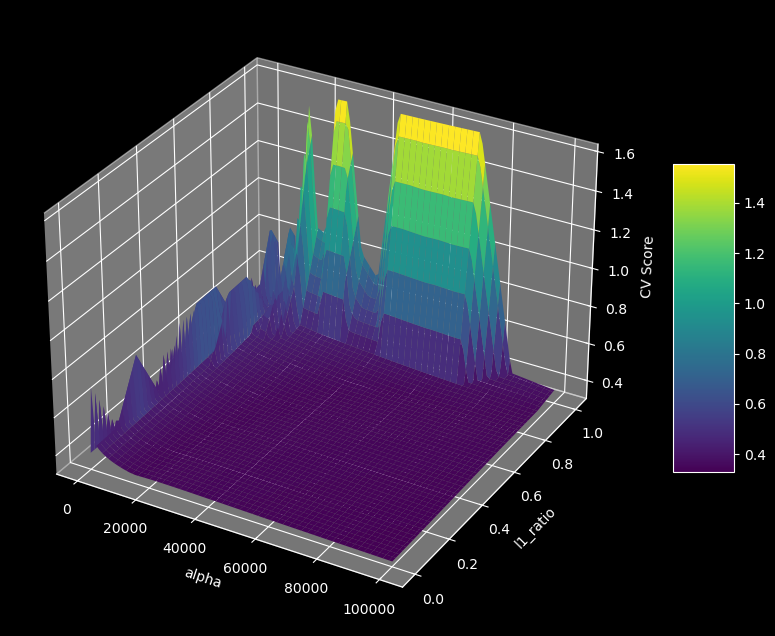

In [638]:
import scipy.interpolate


alpha_range = np.linspace(min(alphas_params), max(alphas_params), 100)
l1_ratio_range = np.linspace(min(l1_ratio_params), max(l1_ratio_params), 100)
alpha_grid, l1_ratio_grid = np.meshgrid(alpha_range, l1_ratio_range)

Z = scipy.interpolate.griddata(
    (alphas_params, l1_ratio_params),
    cv_avrgs,
    (alpha_grid, l1_ratio_grid),
    method='linear'
)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(alpha_grid, l1_ratio_grid, Z, cmap='viridis')
ax.set_xlabel('alpha')
ax.set_ylabel('l1_ratio')
ax.set_zlabel('CV Score')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Mozhit da zaprimetime deka loss function fakat plateau, sho znachit deka okey parametri imame. 

Imat tro poloshi preformansi od Lasso i od LinearRegression, bidejki ne gi nulirat tolku strogo ko Lasso ili ko sho prevme so dropvenjeto pri LinearRegression. 